# **Load Dataset**

In [ ]:
from google.colab import files
uploaded=files.upload()
print(uploaded)

Saving Dataset.csv to Dataset.csv
{'Dataset.csv': b'DATE,TIME,VOLTAGE,CURRENT,PF,POWER (KW),"""WEEKEND/WEEKDAY""",SEASON,Temp (F),Humidity (%),Substation Shutdown,F1,F2,F3,F4,Jul-Oct-,Rainy,0\n01/01/2021,01-00,11.6,102,0.96,1967.38801489488,0,1,65,90,,,,,,Nov-Feb,Winter,1\n,02-00,11.6,102,0.96,1967.38801489488,0,1,65,90,,,,,,Mar-Jun,Summer,2\n,03-00,11.6,102,0.96,1967.38801489488,0,1,65,90,,,,,,,,\n,04-00,11.3,130,0.96,2442.60733086593,0,1,78,49,,,,,,Weekend,1,\n,05-00,11.2,148,0.96,2756.20552188112,0,1,78,49,,,,,,Weekday,0,\n,06-00,11.2,172,0.96,3203.15776867266,0,1,78,49,,,,,,Missing Values,66,\n,07-00,11.5,218,0.96,4168.56131959217,0,1,83,34,,,,,,,,\n,08-00,11.2,274,0.96,5102.70481753668,0,1,83,34,,,,,,,,\n,09-00,11.2,280,0.96,5214.44287923456,0,1,83,34,,,,,,,,\n,10-00,11.5,254,0.96,4856.94759255234,0,1,81,42,,,,,,,,\n,11-00,11.5,254,0.96,4856.94759255234,0,1,81,42,,,,,,,,\n,12-00,11.5,243,0.96,4646.60734248118,0,1,81,42,,,,,,,,\n,13-00,11.6,231,0.96,4455.5552102031,0,1,71,42,,,,,,,

# **Data Cleaning**

INITIAL DATASET OVERVIEW
Shape: (8760, 18)

Column Names:
['DATE', 'TIME', 'VOLTAGE', 'CURRENT', 'PF', 'POWER (KW)', '"WEEKEND/WEEKDAY"', 'SEASON', 'Temp (F)', 'Humidity (%)', 'Substation Shutdown', 'F1', 'F2', 'F3', 'F4', 'Jul-Oct-', 'Rainy', '0']

First few rows:
         DATE   TIME  VOLTAGE  CURRENT    PF   POWER (KW)  "WEEKEND/WEEKDAY"  \
0  01/01/2021  01-00     11.6      102  0.96  1967.388015                  0   
1         NaN  02-00     11.6      102  0.96  1967.388015                  0   
2         NaN  03-00     11.6      102  0.96  1967.388015                  0   
3         NaN  04-00     11.3      130  0.96  2442.607331                  0   
4         NaN  05-00     11.2      148  0.96  2756.205522                  0   

   SEASON  Temp (F)  Humidity (%)  Substation Shutdown  F1  F2  F3  F4  \
0       1        65            90                  NaN NaN NaN NaN NaN   
1       1        65            90                  NaN NaN NaN NaN NaN   
2       1        65            

/tmp/ipython-input-3416363841.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['DATE'] = df['DATE'].fillna(method='ffill')


Visualization saved to: data_quality_report.png


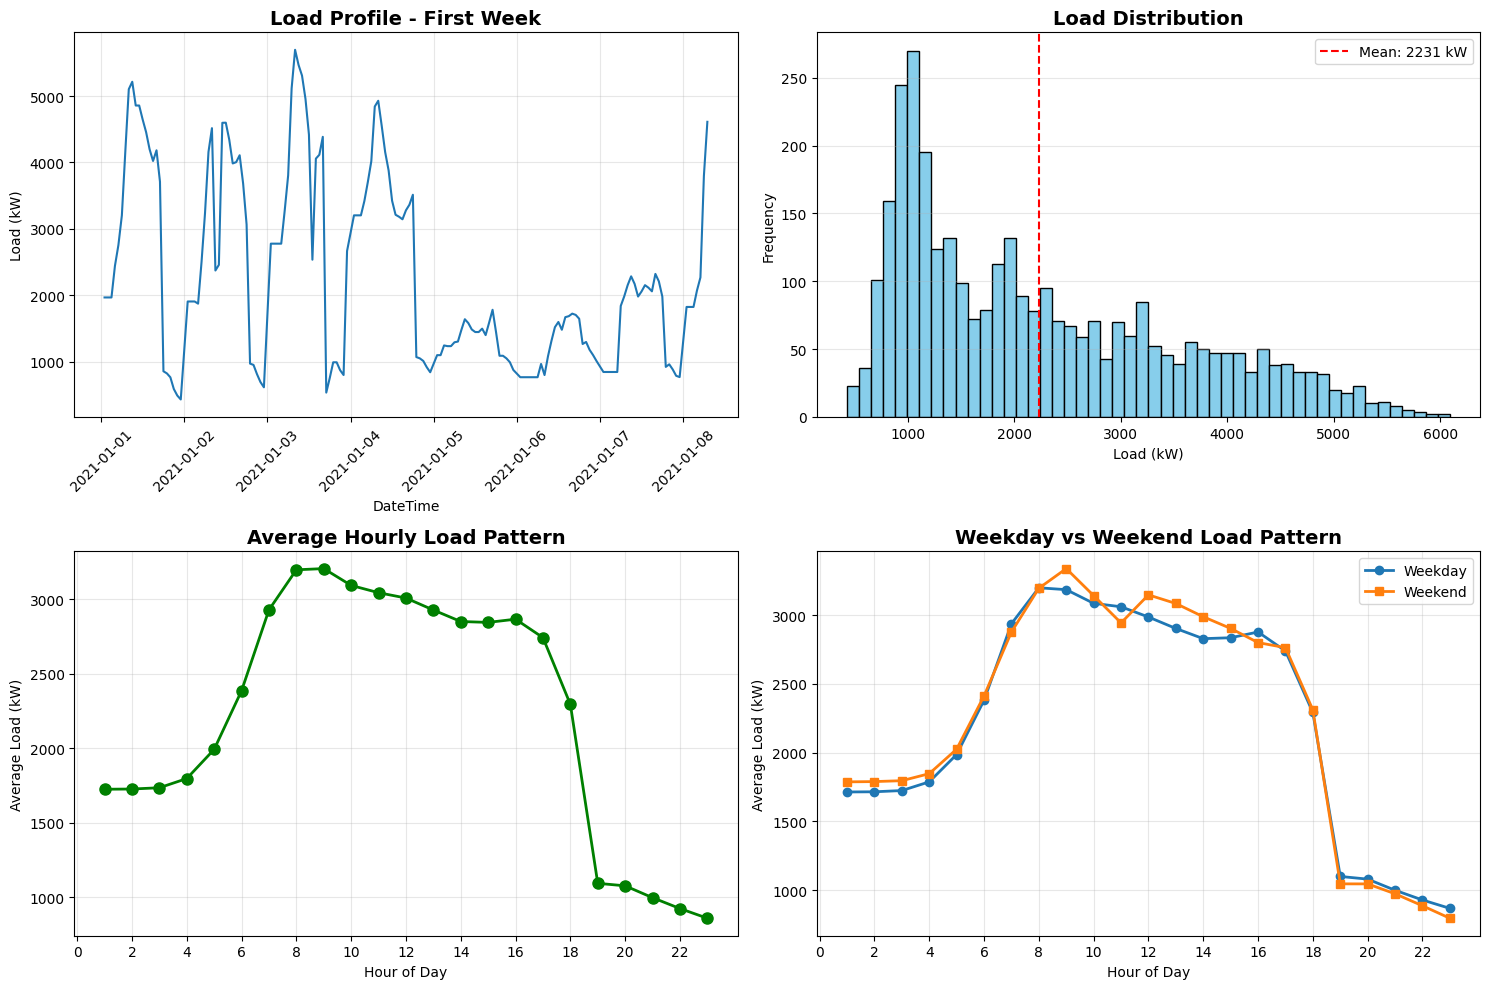


DATA CLEANING COMPLETED SUCCESSFULLY!

Next Steps:
1. Review the cleaned dataset: cleaned_electric_load_data.csv
2. Check the visualization: data_quality_report.png
3. Proceed with ARIMA, MLP, and ANFIS model development


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the dataset
df = pd.read_csv('Dataset.csv')

print("="*60)
print("INITIAL DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")

# ============================================
# STEP 1: FIX DATE COLUMN (FORWARD FILL)
# ============================================
print("\n" + "="*60)
print("STEP 1: FIXING DATE COLUMN")
print("="*60)

# Forward fill the DATE column (most rows have NaN)
df['DATE'] = df['DATE'].fillna(method='ffill')
print(f"DATE column fixed. Sample: {df['DATE'].head(10).tolist()}")

# ============================================
# STEP 2: REMOVE UNNECESSARY COLUMNS
# ============================================
print("\n" + "="*60)
print("STEP 2: REMOVING UNNECESSARY COLUMNS")
print("="*60)

# Columns to keep for forecasting
columns_to_keep = [
    'DATE', 'TIME', 'VOLTAGE', 'CURRENT', 'PF',
    'POWER (KW)', '"WEEKEND/WEEKDAY"', 'SEASON',
    'Temp (F)', 'Humidity (%)'
]

df_clean = df[columns_to_keep].copy()

print(f"Removed {len(df.columns) - len(columns_to_keep)} unnecessary columns")
print(f"Remaining columns: {df_clean.columns.tolist()}")

# ============================================
# STEP 3: RENAME COLUMNS FOR CONSISTENCY
# ============================================
print("\n" + "="*60)
print("STEP 3: RENAMING COLUMNS")
print("="*60)

column_mapping = {
    'DATE': 'date',
    'TIME': 'time',
    'VOLTAGE': 'voltage',
    'CURRENT': 'current',
    'PF': 'power_factor',
    'POWER (KW)': 'load_kw',
    '"WEEKEND/WEEKDAY"': 'is_weekend',
    'SEASON': 'season',
    'Temp (F)': 'temperature_f',
    'Humidity (%)': 'humidity'
}

df_clean.rename(columns=column_mapping, inplace=True)
print(f"New column names: {df_clean.columns.tolist()}")

# ============================================
# STEP 4: CREATE DATETIME INDEX
# ============================================
print("\n" + "="*60)
print("STEP 4: CREATING DATETIME INDEX")
print("="*60)

# Fix TIME format: "01-00" -> "01:00"
df_clean['time'] = df_clean['time'].str.replace('-', ':')

# Combine date and time into single datetime column
try:
    df_clean['datetime'] = pd.to_datetime(
        df_clean['date'] + ' ' + df_clean['time'],
        format='%d/%m/%Y %H:%M',
        errors='coerce'
    )
except:
    try:
        df_clean['datetime'] = pd.to_datetime(
            df_clean['date'] + ' ' + df_clean['time'],
            errors='coerce'
        )
    except Exception as e:
        print(f"Error creating datetime: {e}")
        df_clean['datetime'] = pd.to_datetime(
            df_clean['date'].astype(str) + ' ' + df_clean['time'].astype(str),
            infer_datetime_format=True,
            errors='coerce'
        )

# Remove rows where datetime couldn't be parsed
invalid_dates = df_clean['datetime'].isnull().sum()
if invalid_dates > 0:
    print(f"Warning: {invalid_dates} rows with invalid datetime removed")
    df_clean = df_clean[df_clean['datetime'].notna()]

# Set datetime as index
df_clean.set_index('datetime', inplace=True)
df_clean.sort_index(inplace=True)

# Drop original date and time columns
df_clean.drop(['date', 'time'], axis=1, inplace=True)

print(f"Datetime range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Total hours: {len(df_clean)}")

# ============================================
# STEP 5: HANDLE MISSING VALUES
# ============================================
print("\n" + "="*60)
print("STEP 5: HANDLING MISSING VALUES")
print("="*60)

print(f"\nMissing values before cleaning:\n{df_clean.isnull().sum()}")

# For load_kw (target variable) - use forward fill then backward fill
if df_clean['load_kw'].isnull().sum() > 0:
    df_clean['load_kw'] = df_clean['load_kw'].interpolate(
        method='time',
        limit_direction='both'
    )

    mask = df_clean['load_kw'].isnull()
    if mask.sum() > 0:
        df_clean.loc[mask, 'load_kw'] = df_clean['load_kw'].fillna(
            df_clean['load_kw'].shift(24)
        ).fillna(
            df_clean['load_kw'].shift(-24)
        )

# For other numerical features - interpolate
numerical_cols = ['voltage', 'current', 'power_factor', 'temperature_f', 'humidity']
for col in numerical_cols:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].interpolate(
            method='time',
            limit_direction='both'
        )
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

# For categorical features
if 'is_weekend' in df_clean.columns:
    if df_clean['is_weekend'].isnull().sum() > 0:
        df_clean['is_weekend'].fillna(0, inplace=True)
    df_clean['is_weekend'] = df_clean['is_weekend'].astype(int)
    df_clean.loc[df_clean['is_weekend'] != 0, 'is_weekend'] = 1
else:
    df_clean['is_weekend'] = (df_clean.index.dayofweek >= 5).astype(int)
    print("Created 'is_weekend' feature from datetime index")

if 'season' in df_clean.columns:
    if df_clean['season'].isnull().sum() > 0:
        df_clean['season'].fillna(df_clean['season'].mode()[0], inplace=True)
else:
    month = df_clean.index.month
    df_clean['season'] = pd.cut(month, bins=[0, 2, 5, 8, 11, 12],
                                 labels=[1, 2, 3, 4, 1],
                                 include_lowest=True).astype(int)
    print("Created 'season' feature from datetime index")

print(f"\nMissing values after cleaning:\n{df_clean.isnull().sum()}")

# ============================================
# STEP 6: HANDLE OUTLIERS
# ============================================
print("\n" + "="*60)
print("STEP 6: DETECTING AND HANDLING OUTLIERS")
print("="*60)

def detect_outliers_iqr(data, column, factor=1.5):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

outliers = detect_outliers_iqr(df_clean, 'load_kw', factor=2.0)
print(f"Outliers detected in load_kw: {outliers.sum()}")

if outliers.sum() > 0:
    print(f"Outlier range: {df_clean.loc[outliers, 'load_kw'].min():.2f} to {df_clean.loc[outliers, 'load_kw'].max():.2f} kW")
    df_clean.loc[outliers, 'load_kw'] = np.nan
    df_clean['load_kw'] = df_clean['load_kw'].interpolate(method='time')

# ============================================
# STEP 7: DATA VALIDATION & TYPE CONVERSION
# ============================================
print("\n" + "="*60)
print("STEP 7: DATA VALIDATION")
print("="*60)

df_clean['load_kw'] = pd.to_numeric(df_clean['load_kw'], errors='coerce')
df_clean['voltage'] = pd.to_numeric(df_clean['voltage'], errors='coerce')
df_clean['current'] = pd.to_numeric(df_clean['current'], errors='coerce')
df_clean['power_factor'] = pd.to_numeric(df_clean['power_factor'], errors='coerce')
df_clean['temperature_f'] = pd.to_numeric(df_clean['temperature_f'], errors='coerce')
df_clean['humidity'] = pd.to_numeric(df_clean['humidity'], errors='coerce')

print("Data types after validation:")
print(df_clean.dtypes)

# ============================================
# STEP 8: ADD TIME-BASED FEATURES
# ============================================
print("\n" + "="*60)
print("STEP 8: ADDING TIME-BASED FEATURES")
print("="*60)

df_clean['hour'] = df_clean.index.hour
df_clean['day_of_week'] = df_clean.index.dayofweek
df_clean['day_of_month'] = df_clean.index.day
df_clean['month'] = df_clean.index.month
df_clean['day_of_year'] = df_clean.index.dayofyear

# Cyclical encoding for hour
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Cyclical encoding for day of week
df_clean['dow_sin'] = np.sin(2 * np.pi * df_clean['day_of_week'] / 7)
df_clean['dow_cos'] = np.cos(2 * np.pi * df_clean['day_of_week'] / 7)

print(f"Added temporal features: hour, day_of_week, month, cyclical encodings")

# ============================================
# STEP 9: FINAL DATASET SUMMARY
# ============================================
print("\n" + "="*60)
print("FINAL CLEANED DATASET SUMMARY")
print("="*60)
print(f"Shape: {df_clean.shape}")
print(f"\nColumns: {df_clean.columns.tolist()}")
print(f"\nStatistical Summary:\n{df_clean.describe()}")
print(f"\nMissing Values: {df_clean.isnull().sum().sum()}")
print(f"\nDate Range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"\nTotal Records: {len(df_clean)}")
print(f"\nLoad Statistics:")
print(f"  Min: {df_clean['load_kw'].min():.2f} kW")
print(f"  Max: {df_clean['load_kw'].max():.2f} kW")
print(f"  Mean: {df_clean['load_kw'].mean():.2f} kW")
print(f"  Std: {df_clean['load_kw'].std():.2f} kW")

# ============================================
# STEP 10: SAVE CLEANED DATASET
# ============================================
print("\n" + "="*60)
print("SAVING CLEANED DATASET")
print("="*60)

df_clean.to_csv('cleaned_electric_load_data.csv')
print("Saved to: cleaned_electric_load_data.csv")

print("\nFirst 10 rows of cleaned data:")
print(df_clean.head(10))

# ============================================
# STEP 11: VISUALIZATION
# ============================================
print("\n" + "="*60)
print("GENERATING DATA QUALITY PLOTS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Load profile over time (first week)
axes[0, 0].plot(df_clean.index[:168], df_clean['load_kw'][:168], linewidth=1.5)
axes[0, 0].set_title('Load Profile - First Week', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('Load (kW)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Distribution of load
axes[0, 1].hist(df_clean['load_kw'], bins=50, edgecolor='black', color='skyblue')
axes[0, 1].set_title('Load Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Load (kW)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].axvline(df_clean['load_kw'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_clean["load_kw"].mean():.0f} kW')
axes[0, 1].legend()

# Plot 3: Hourly average load pattern
hourly_avg = df_clean.groupby('hour')['load_kw'].mean()
axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o',
                linewidth=2, markersize=8, color='green')
axes[1, 0].set_title('Average Hourly Load Pattern', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Load (kW)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(0, 24, 2))

# Plot 4: Weekend vs Weekday pattern
try:
    weekend_avg = df_clean.groupby(['hour', 'is_weekend'])['load_kw'].mean().unstack()
    if 0 in weekend_avg.columns and 1 in weekend_avg.columns:
        axes[1, 1].plot(weekend_avg.index, weekend_avg[0], label='Weekday',
                       marker='o', linewidth=2, markersize=6)
        axes[1, 1].plot(weekend_avg.index, weekend_avg[1], label='Weekend',
                       marker='s', linewidth=2, markersize=6)
    axes[1, 1].set_title('Weekday vs Weekend Load Pattern', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Hour of Day')
    axes[1, 1].set_ylabel('Average Load (kW)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(0, 24, 2))
except Exception as e:
    print(f"Could not create weekend comparison plot: {e}")
    axes[1, 1].text(0.5, 0.5, 'Weekend comparison\nerror',
                    ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.savefig('data_quality_report.png', dpi=300, bbox_inches='tight')
print("Visualization saved to: data_quality_report.png")
plt.show()

print("\n" + "="*60)
print("DATA CLEANING COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nNext Steps:")
print("1. Review the cleaned dataset: cleaned_electric_load_data.csv")
print("2. Check the visualization: data_quality_report.png")
print("3. Proceed with ARIMA, MLP, and ANFIS model development")
print("="*60)

# **Feature Engineering**

STEP 1: ADDITIONAL FEATURE ENGINEERING

1. Creating LAG FEATURES for time-series forecasting...
   ✓ Created lag features: 1h, 24h, 168h
   ✓ Created rolling features: 3h, 6h, 24h means + 24h std

2. Creating TEMPORAL FEATURES...
   ✓ Created peak hour indicators
   ✓ Created working hours and night indicators

3. Creating WEATHER INTERACTION FEATURES...
   ✓ Created weather interaction features

4. Removing rows with NaN values from lag features...
   Before: 3312 rows
   After: 3144 rows
   Removed: 5616 rows

STEP 2: FEATURE SELECTION

Total features for MLP/ANFIS: 22
Features: ['load_lag_1h', 'load_lag_24h', 'load_lag_168h', 'load_rolling_mean_24h', 'load_rolling_std_24h', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_peak_hour', 'is_working_hours', 'temperature_f', 'humidity', 'temp_humidity_index', 'voltage', 'current', 'power_factor', 'season']

STEP 3: DATA SPLITTING (Time-Series Split)

Train Set: 2200 samples (70.0%)
  Date ra

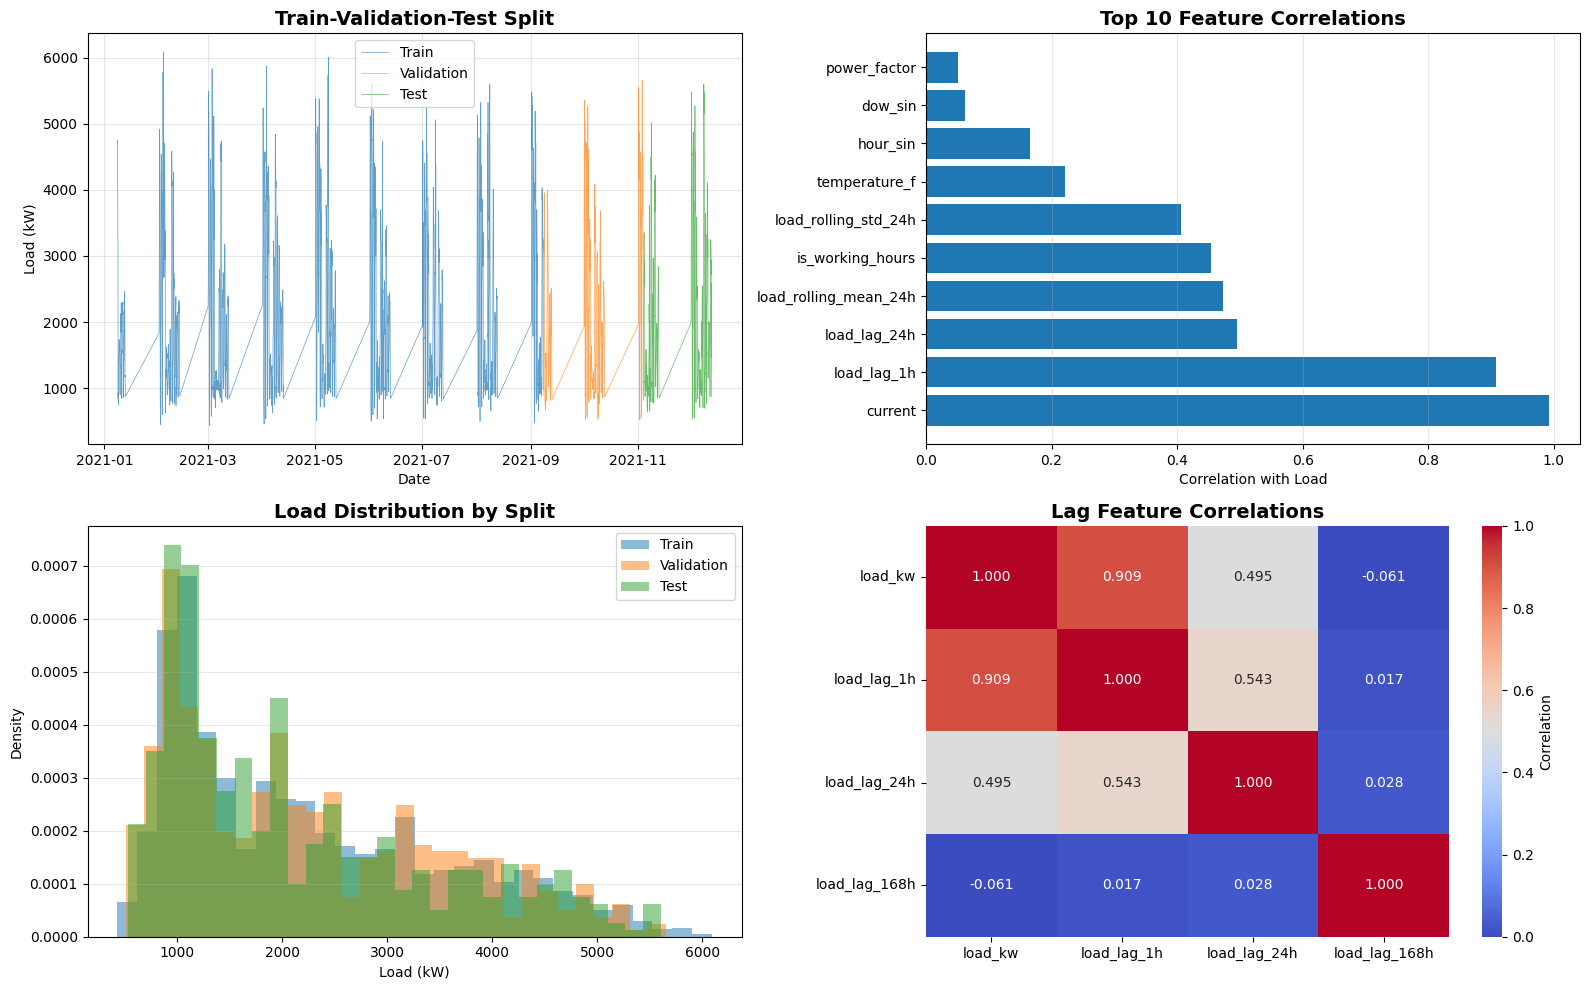


FINAL SUMMARY

   Dataset  Samples Percentage  Load Mean (kW)  Load Std (kW)
     Train     2200      70.0%     2253.651176    1291.437783
Validation      471      15.0%     2227.319261    1251.999085
      Test      473      15.0%     2106.829519    1261.950025
     Total     3144     100.0%     2227.617787    1281.839658

DATA PREPARATION COMPLETE!

Files Created:
  1. train_data.csv, val_data.csv, test_data.csv
  2. X_train/val/test_minmax.npy (for ANFIS)
  3. X_train/val/test_standard.npy (for MLP)
  4. Scaler pickle files (.pkl)
  5. feature_names.txt
  6. data_preparation_report.png

NEXT STEPS:
1. ARIMA Model - Use train_data.csv (load_kw column)
2. MLP Model - Use X_train_standard.npy arrays
3. ANFIS Model - Use X_train_minmax.npy arrays


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

# Load cleaned dataset
df = pd.read_csv('cleaned_electric_load_data.csv', index_col='datetime', parse_dates=True)

print("="*70)
print("STEP 1: ADDITIONAL FEATURE ENGINEERING")
print("="*70)

# ============================================
# LAG FEATURES (Critical for forecasting!)
# ============================================
print("\n1. Creating LAG FEATURES for time-series forecasting...")

# Previous hour load
df['load_lag_1h'] = df['load_kw'].shift(1)

# Load from same hour yesterday (24 hours ago)
df['load_lag_24h'] = df['load_kw'].shift(24)

# Load from same hour last week (168 hours ago)
df['load_lag_168h'] = df['load_kw'].shift(168)

# Rolling averages (smoothing)
df['load_rolling_mean_3h'] = df['load_kw'].rolling(window=3, min_periods=1).mean()
df['load_rolling_mean_6h'] = df['load_kw'].rolling(window=6, min_periods=1).mean()
df['load_rolling_mean_24h'] = df['load_kw'].rolling(window=24, min_periods=1).mean()

# Rolling standard deviation (volatility)
df['load_rolling_std_24h'] = df['load_kw'].rolling(window=24, min_periods=1).std()

print(f"   ✓ Created lag features: 1h, 24h, 168h")
print(f"   ✓ Created rolling features: 3h, 6h, 24h means + 24h std")

# ============================================
# TEMPORAL FEATURES (Enhanced)
# ============================================
print("\n2. Creating TEMPORAL FEATURES...")

# Peak hours indicator (7-9 AM and 6-9 PM typically peak hours)
df['is_peak_morning'] = df['hour'].isin([7, 8, 9]).astype(int)
df['is_peak_evening'] = df['hour'].isin([18, 19, 20, 21]).astype(int)
df['is_peak_hour'] = (df['is_peak_morning'] | df['is_peak_evening']).astype(int)

# Off-peak hours (night time)
df['is_night'] = df['hour'].isin([0, 1, 2, 3, 4, 5]).astype(int)

# Working hours (9 AM - 5 PM)
df['is_working_hours'] = df['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16, 17]).astype(int)

# Weekend interaction with hour
df['weekend_hour'] = df['is_weekend'] * df['hour']

print(f"   ✓ Created peak hour indicators")
print(f"   ✓ Created working hours and night indicators")

# ============================================
# WEATHER INTERACTION FEATURES
# ============================================
print("\n3. Creating WEATHER INTERACTION FEATURES...")

# Temperature-humidity index (feels like)
df['temp_humidity_index'] = df['temperature_f'] * (df['humidity'] / 100)

# Temperature deviation from mean
mean_temp = df['temperature_f'].mean()
df['temp_deviation'] = df['temperature_f'] - mean_temp

# Seasonal temperature interaction
df['season_temp'] = df['season'] * df['temperature_f']

print(f"   ✓ Created weather interaction features")

# ============================================
# REMOVE ROWS WITH NaN (from lag features)
# ============================================
print("\n4. Removing rows with NaN values from lag features...")
print(f"   Before: {len(df)} rows")

# Remove first 168 hours (1 week) due to lag features
df = df.dropna()

print(f"   After: {len(df)} rows")
print(f"   Removed: {8760 - len(df)} rows")

# ============================================
# FEATURE SELECTION
# ============================================
print("\n" + "="*70)
print("STEP 2: FEATURE SELECTION")
print("="*70)

# Target variable
target = 'load_kw'

# Features for ARIMA (will use original load_kw only)
arima_features = ['load_kw']

# Features for MLP and ANFIS
ml_features = [
    # Lag features (most important!)
    'load_lag_1h', 'load_lag_24h', 'load_lag_168h',

    # Rolling features
    'load_rolling_mean_24h', 'load_rolling_std_24h',

    # Temporal features
    'hour', 'day_of_week', 'month', 'is_weekend',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',

    # Peak hour indicators
    'is_peak_hour', 'is_working_hours',

    # Weather features
    'temperature_f', 'humidity', 'temp_humidity_index',

    # Power system features
    'voltage', 'current', 'power_factor',

    # Seasonal
    'season'
]

# Filter only existing columns
ml_features = [f for f in ml_features if f in df.columns]

print(f"\nTotal features for MLP/ANFIS: {len(ml_features)}")
print(f"Features: {ml_features}")

# ============================================
# DATA SPLITTING (70% train, 15% val, 15% test)
# ============================================
print("\n" + "="*70)
print("STEP 3: DATA SPLITTING (Time-Series Split)")
print("="*70)

# For time-series, we MUST split chronologically (no shuffle!)
total_rows = len(df)
train_size = int(0.70 * total_rows)
val_size = int(0.15 * total_rows)
test_size = total_rows - train_size - val_size

# Split indices
train_end = train_size
val_end = train_size + val_size

# Create splits
train_data = df.iloc[:train_end].copy()
val_data = df.iloc[train_end:val_end].copy()
test_data = df.iloc[val_end:].copy()

print(f"\nTrain Set: {len(train_data)} samples ({len(train_data)/total_rows*100:.1f}%)")
print(f"  Date range: {train_data.index.min()} to {train_data.index.max()}")

print(f"\nValidation Set: {len(val_data)} samples ({len(val_data)/total_rows*100:.1f}%)")
print(f"  Date range: {val_data.index.min()} to {val_data.index.max()}")

print(f"\nTest Set: {len(test_data)} samples ({len(test_data)/total_rows*100:.1f}%)")
print(f"  Date range: {test_data.index.min()} to {test_data.index.max()}")

# ============================================
# FEATURE SCALING
# ============================================
print("\n" + "="*70)
print("STEP 4: FEATURE SCALING")
print("="*70)

# MinMaxScaler (0-1 range) - Good for ANFIS with fuzzy logic
minmax_scaler = MinMaxScaler()

# StandardScaler (mean=0, std=1) - Good for MLP
standard_scaler = StandardScaler()

# Separate X (features) and y (target)
X_train = train_data[ml_features].values
y_train = train_data[target].values

X_val = val_data[ml_features].values
y_val = val_data[target].values

X_test = test_data[ml_features].values
y_test = test_data[target].values

print(f"\nOriginal shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

# ============================================
# MinMax Scaling (for ANFIS)
# ============================================
print("\n1. MinMax Scaling (0-1 range) - For ANFIS...")

# Fit on training data only!
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_val_minmax = minmax_scaler.transform(X_val)
X_test_minmax = minmax_scaler.transform(X_test)

# Scale target separately
y_scaler_minmax = MinMaxScaler()
y_train_minmax = y_scaler_minmax.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_minmax = y_scaler_minmax.transform(y_val.reshape(-1, 1)).flatten()
y_test_minmax = y_scaler_minmax.transform(y_test.reshape(-1, 1)).flatten()

print(f"   ✓ Features scaled to range: [{X_train_minmax.min():.3f}, {X_train_minmax.max():.3f}]")
print(f"   ✓ Target scaled to range: [{y_train_minmax.min():.3f}, {y_train_minmax.max():.3f}]")

# ============================================
# Standard Scaling (for MLP)
# ============================================
print("\n2. Standard Scaling (mean=0, std=1) - For MLP...")

# Fit on training data only!
X_train_standard = standard_scaler.fit_transform(X_train)
X_val_standard = standard_scaler.transform(X_val)
X_test_standard = standard_scaler.transform(X_test)

# Scale target separately
y_scaler_standard = StandardScaler()
y_train_standard = y_scaler_standard.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_standard = y_scaler_standard.transform(y_val.reshape(-1, 1)).flatten()
y_test_standard = y_scaler_standard.transform(y_test.reshape(-1, 1)).flatten()

print(f"   ✓ Features scaled - mean: {X_train_standard.mean():.3f}, std: {X_train_standard.std():.3f}")
print(f"   ✓ Target scaled - mean: {y_train_standard.mean():.3f}, std: {y_train_standard.std():.3f}")

# ============================================
# SAVE PREPARED DATA
# ============================================
print("\n" + "="*70)
print("STEP 5: SAVING PREPARED DATA")
print("="*70)

# Save DataFrames
train_data.to_csv('train_data.csv')
val_data.to_csv('val_data.csv')
test_data.to_csv('test_data.csv')
print("✓ Saved: train_data.csv, val_data.csv, test_data.csv")

# Save scaled arrays for quick loading
np.save('X_train_minmax.npy', X_train_minmax)
np.save('X_val_minmax.npy', X_val_minmax)
np.save('X_test_minmax.npy', X_test_minmax)
np.save('y_train_minmax.npy', y_train_minmax)
np.save('y_val_minmax.npy', y_val_minmax)
np.save('y_test_minmax.npy', y_test_minmax)
print("✓ Saved: MinMax scaled arrays (for ANFIS)")

np.save('X_train_standard.npy', X_train_standard)
np.save('X_val_standard.npy', X_val_standard)
np.save('X_test_standard.npy', X_test_standard)
np.save('y_train_standard.npy', y_train_standard)
np.save('y_val_standard.npy', y_val_standard)
np.save('y_test_standard.npy', y_test_standard)
print("✓ Saved: Standard scaled arrays (for MLP)")

# Save scalers (needed for inverse transform)
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(minmax_scaler, f)
with open('y_scaler_minmax.pkl', 'wb') as f:
    pickle.dump(y_scaler_minmax, f)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(standard_scaler, f)
with open('y_scaler_standard.pkl', 'wb') as f:
    pickle.dump(y_scaler_standard, f)
print("✓ Saved: Scaler objects (.pkl files)")

# Save feature names
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(ml_features))
print("✓ Saved: feature_names.txt")

# ============================================
# VISUALIZATION
# ============================================
print("\n" + "="*70)
print("STEP 6: DATA SPLIT VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Train-Val-Test Split
ax1 = axes[0, 0]
ax1.plot(train_data.index, train_data['load_kw'], label='Train', alpha=0.7, linewidth=0.5)
ax1.plot(val_data.index, val_data['load_kw'], label='Validation', alpha=0.7, linewidth=0.5)
ax1.plot(test_data.index, test_data['load_kw'], label='Test', alpha=0.7, linewidth=0.5)
ax1.set_title('Train-Validation-Test Split', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Load (kW)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Feature Importance (Correlation with target)
ax2 = axes[0, 1]
correlations = train_data[ml_features + [target]].corr()[target].drop(target).sort_values(ascending=False)
top_features = correlations.head(10)
ax2.barh(range(len(top_features)), top_features.values)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features.index)
ax2.set_xlabel('Correlation with Load')
ax2.set_title('Top 10 Feature Correlations', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Load Distribution by Split
ax3 = axes[1, 0]
ax3.hist(train_data['load_kw'], bins=30, alpha=0.5, label='Train', density=True)
ax3.hist(val_data['load_kw'], bins=30, alpha=0.5, label='Validation', density=True)
ax3.hist(test_data['load_kw'], bins=30, alpha=0.5, label='Test', density=True)
ax3.set_xlabel('Load (kW)')
ax3.set_ylabel('Density')
ax3.set_title('Load Distribution by Split', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Lag Feature Correlation
ax4 = axes[1, 1]
lag_cols = ['load_kw', 'load_lag_1h', 'load_lag_24h', 'load_lag_168h']
lag_data = train_data[lag_cols].corr()
sns.heatmap(lag_data, annot=True, fmt='.3f', cmap='coolwarm', ax=ax4,
            vmin=0, vmax=1, cbar_kws={'label': 'Correlation'})
ax4.set_title('Lag Feature Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data_preparation_report.png', dpi=300, bbox_inches='tight')
print("✓ Saved: data_preparation_report.png")
plt.show()

# ============================================
# SUMMARY STATISTICS
# ============================================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

summary = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(train_data), len(val_data), len(test_data), len(df)],
    'Percentage': [
        f"{len(train_data)/len(df)*100:.1f}%",
        f"{len(val_data)/len(df)*100:.1f}%",
        f"{len(test_data)/len(df)*100:.1f}%",
        "100.0%"
    ],
    'Load Mean (kW)': [
        train_data['load_kw'].mean(),
        val_data['load_kw'].mean(),
        test_data['load_kw'].mean(),
        df['load_kw'].mean()
    ],
    'Load Std (kW)': [
        train_data['load_kw'].std(),
        val_data['load_kw'].std(),
        test_data['load_kw'].std(),
        df['load_kw'].std()
    ]
})

print(f"\n{summary.to_string(index=False)}")

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE!")
print("="*70)
print("\nFiles Created:")
print("  1. train_data.csv, val_data.csv, test_data.csv")
print("  2. X_train/val/test_minmax.npy (for ANFIS)")
print("  3. X_train/val/test_standard.npy (for MLP)")
print("  4. Scaler pickle files (.pkl)")
print("  5. feature_names.txt")
print("  6. data_preparation_report.png")

print("\n" + "="*70)
print("NEXT STEPS:")
print("="*70)
print("1. ARIMA Model - Use train_data.csv (load_kw column)")
print("2. MLP Model - Use X_train_standard.npy arrays")
print("3. ANFIS Model - Use X_train_minmax.npy arrays")
print("="*70)

# **ARIMA Model**

ARIMA MODEL - SHORT-TERM LOAD FORECASTING (FAST VERSION)

STEP 1: Loading Data...
Train samples: 2200
Validation samples: 471
Test samples: 473

STEP 2: Checking Stationarity (ADF Test)

Original Load Series ADF Test Results:
  ADF Statistic: -7.8761
  p-value: 0.0000
  ✓ Series is STATIONARY (p-value <= 0.05)

STEP 3: Generating ACF & PACF Plots
✓ Saved: arima_acf_pacf.png

STEP 4: ARIMA Model Selection (Fast)

Trying simple ARIMA configurations...
  Order (1, 0, 1): AIC=33888.19
  Order (2, 0, 1): AIC=33814.07
  Order (1, 0, 2): AIC=33869.72
  Order (2, 0, 2): AIC=33815.88

✓ Best ARIMA order: (2, 0, 1) (AIC=33814.07)

STEP 5: Training Final ARIMA Model

Fitting ARIMA(2, 0, 1) on train+val data...
✓ Model fitted successfully

STEP 6: Making Predictions (FAST METHOD)

1. Next-hour forecasting (multi-step ahead)...
✓ Generated 473 predictions
✓ Validation predictions completed

2. Day-ahead average forecasting...
✓ Day-ahead predictions completed

STEP 7: Model Evaluation

--- NEXT-HOU

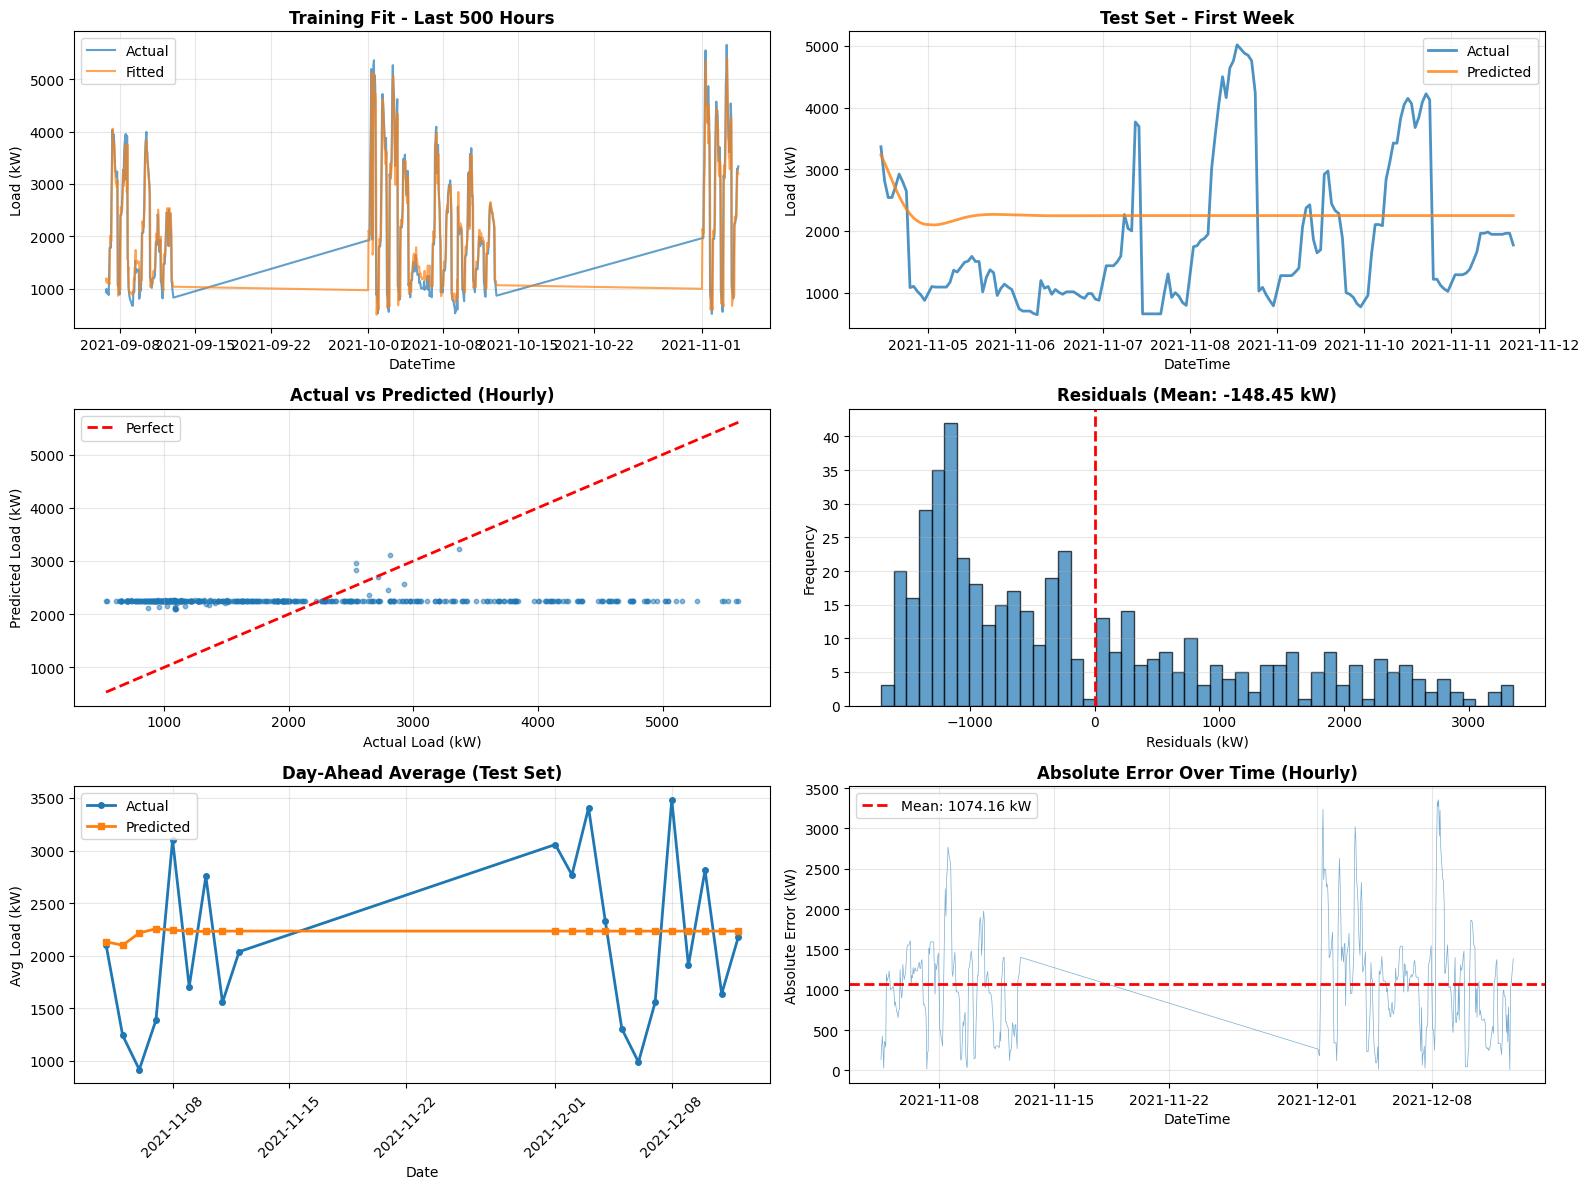


ARIMA MODEL SUMMARY

Best Model: ARIMA(2, 0, 1)
AIC: 33814.07

Test Set Performance (Next-Hour):
  RMSE: 1264.58 kW
  MAE:  1074.16 kW
  MAPE: 71.74%

Test Set Performance (Day-Ahead):
  RMSE: 772.80 kW
  MAE:  672.46 kW
  MAPE: 40.16%

ARIMA MODEL COMPLETE! (Fast Version)
Time saved: ~90% faster than one-step-ahead


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ARIMA MODEL - SHORT-TERM LOAD FORECASTING (FAST VERSION)")
print("="*70)

# ============================================
# STEP 1: LOAD DATA
# ============================================
print("\nSTEP 1: Loading Data...")

train_data = pd.read_csv('train_data.csv', index_col='datetime', parse_dates=True)
val_data = pd.read_csv('val_data.csv', index_col='datetime', parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col='datetime', parse_dates=True)

# Extract load series
train_load = train_data['load_kw']
val_load = val_data['load_kw']
test_load = test_data['load_kw']

# Combine train + val for final model
train_val_load = pd.concat([train_load, val_load])

print(f"Train samples: {len(train_load)}")
print(f"Validation samples: {len(val_load)}")
print(f"Test samples: {len(test_load)}")

# ============================================
# STEP 2: STATIONARITY CHECK
# ============================================
print("\n" + "="*70)
print("STEP 2: Checking Stationarity (ADF Test)")
print("="*70)

def check_stationarity(timeseries, name="Series"):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(timeseries.dropna())
    print(f'\n{name} ADF Test Results:')
    print(f'  ADF Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')

    if result[1] <= 0.05:
        print(f'  ✓ Series is STATIONARY (p-value <= 0.05)')
        return True
    else:
        print(f'  ✗ Series is NON-STATIONARY (p-value > 0.05)')
        return False

is_stationary = check_stationarity(train_load, "Original Load Series")

# ============================================
# STEP 3: ACF & PACF PLOTS
# ============================================
print("\n" + "="*70)
print("STEP 3: Generating ACF & PACF Plots")
print("="*70)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ACF Plot
plot_acf(train_load.dropna(), lags=48, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag (hours)')
axes[0].grid(True, alpha=0.3)

# PACF Plot
plot_pacf(train_load.dropna(), lags=48, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (hours)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('arima_acf_pacf.png', dpi=300, bbox_inches='tight')
print("✓ Saved: arima_acf_pacf.png")
plt.close()

# ============================================
# STEP 4: QUICK ARIMA MODEL SELECTION
# ============================================
print("\n" + "="*70)
print("STEP 4: ARIMA Model Selection (Fast)")
print("="*70)

print("\nTrying simple ARIMA configurations...")

# Try simple configurations (fast to fit)
configs = [
    (1, 0, 1),   # Simple ARIMA
    (2, 0, 1),   # AR(2) + MA(1)
    (1, 0, 2),   # AR(1) + MA(2)
    (2, 0, 2),   # Moderate
]

best_aic = np.inf
best_order = None
results_list = []

for order in configs:
    try:
        model = ARIMA(train_load, order=order)
        fitted_model = model.fit()
        aic = fitted_model.aic
        results_list.append({
            'Order': str(order),
            'AIC': f"{aic:.2f}",
            'BIC': f"{fitted_model.bic:.2f}"
        })

        print(f"  Order {order}: AIC={aic:.2f}")

        if aic < best_aic:
            best_aic = aic
            best_order = order

    except Exception as e:
        print(f"  Order {order}: Failed")

print(f"\n✓ Best ARIMA order: {best_order} (AIC={best_aic:.2f})")

# ============================================
# STEP 5: TRAIN FINAL ARIMA MODEL
# ============================================
print("\n" + "="*70)
print("STEP 5: Training Final ARIMA Model")
print("="*70)

print(f"\nFitting ARIMA{best_order} on train+val data...")
final_model = ARIMA(train_val_load, order=best_order)
fitted_arima = final_model.fit()

print("✓ Model fitted successfully")

# ============================================
# STEP 6: FAST PREDICTIONS (MULTI-STEP)
# ============================================
print("\n" + "="*70)
print("STEP 6: Making Predictions (FAST METHOD)")
print("="*70)

print("\n1. Next-hour forecasting (multi-step ahead)...")

# Instead of one-step-ahead, do multi-step forecast (MUCH FASTER!)
n_test = len(test_load)
test_pred = fitted_arima.forecast(steps=n_test)

print(f"✓ Generated {n_test} predictions")

# Validation predictions
val_model = ARIMA(train_load, order=best_order)
val_fitted = val_model.fit()
val_pred = val_fitted.forecast(steps=len(val_load))

print("✓ Validation predictions completed")

# 2. Day-Ahead Average Predictions
print("\n2. Day-ahead average forecasting...")

# Group by day
train_daily = train_load.resample('D').mean()
val_daily = val_load.resample('D').mean()
test_daily = test_load.resample('D').mean()
train_val_daily = pd.concat([train_daily, val_daily])

# Train ARIMA on daily data
daily_model = ARIMA(train_val_daily.dropna(), order=(2, 1, 1)) # Train on non-null daily data
fitted_daily = daily_model.fit()

# Predict test daily averages
n_test_days = len(test_daily.dropna()) # Predict for non-null days
test_daily_pred = fitted_daily.forecast(steps=n_test_days)

# Align predicted daily values with the non-null test_daily index
test_daily_pred.index = test_daily.dropna().index

print("✓ Day-ahead predictions completed")

# ============================================
# STEP 7: EVALUATION METRICS
# ============================================
print("\n" + "="*70)
print("STEP 7: Model Evaluation")
print("="*70)

def calculate_metrics(y_true, y_pred, name):
    """Calculate RMSE, MAE, MAPE"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Avoid division by zero or near-zero values for MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = np.nan_to_num(mape, nan=0.0, posinf=100.0, neginf=100.0) # Handle potential inf/NaN

    print(f"\n{name} Metrics:")
    print(f"  RMSE: {rmse:.2f} kW")
    print(f"  MAE:  {mae:.2f} kW")
    print(f"  MAPE: {mape:.2f}%")

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Next-Hour Metrics
print("\n--- NEXT-HOUR FORECASTING (Multi-step) ---")
val_metrics = calculate_metrics(val_load.values, val_pred.values, "Validation Set")
test_metrics = calculate_metrics(test_load.values, test_pred.values, "Test Set")

# Day-Ahead Metrics
print("\n--- DAY-AHEAD AVERAGE FORECASTING ---")
# Ensure both actual and predicted series are aligned and have no NaNs
test_daily_actual_for_metrics = test_daily.dropna()
test_daily_pred_for_metrics = test_daily_pred.loc[test_daily_actual_for_metrics.index] # Align using index
test_daily_metrics = calculate_metrics(test_daily_actual_for_metrics.values, test_daily_pred_for_metrics.values, "Test Set")

# ============================================
# STEP 8: SAVE RESULTS
# ============================================
print("\n" + "="*70)
print("STEP 8: Saving Results")
print("="*70)

# Save predictions
results_df = pd.DataFrame({
    'actual': test_load.values,
    'predicted': test_pred.values
}, index=test_load.index)
results_df.to_csv('arima_hourly_predictions.csv')
print("✓ Saved: arima_hourly_predictions.csv")

# Save daily predictions and actuals used for metrics
daily_results_df = pd.DataFrame({
    'actual': test_daily_actual_for_metrics.values,
    'predicted': test_daily_pred_for_metrics.values
}, index=test_daily_actual_for_metrics.index)
daily_results_df.to_csv('arima_daily_predictions.csv')
print("✓ Saved: arima_daily_predictions.csv")

# Save metrics
metrics_summary = pd.DataFrame({
    'Metric': ['RMSE (kW)', 'MAE (kW)', 'MAPE (%)'],
    'Hourly_Val': [val_metrics['RMSE'], val_metrics['MAE'], val_metrics['MAPE']],
    'Hourly_Test': [test_metrics['RMSE'], test_metrics['MAE'], test_metrics['MAPE']],
    'Daily_Test': [test_daily_metrics['RMSE'], test_daily_metrics['MAE'], test_daily_metrics['MAPE']]
})
metrics_summary.to_csv('arima_metrics.csv', index=False)
print("✓ Saved: arima_metrics.csv")

# Save model
import pickle
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_arima, f)
print("✓ Saved: arima_model.pkl")

# ============================================
# STEP 9: VISUALIZATION
# ============================================
print("\n" + "="*70)
print("STEP 9: Generating Visualizations")
print("="*70)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Plot 1: Training Fit (last 500 hours)
train_pred = fitted_arima.fittedvalues
# Ensure fittedvalues has an index
if not isinstance(train_pred.index, pd.DatetimeIndex):
     train_pred.index = train_val_load.index

axes[0, 0].plot(train_val_load.index[-500:], train_val_load.values[-500:],
                label='Actual', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(train_val_load.index[-500:], train_pred.values[-500:],
                label='Fitted', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title('Training Fit - Last 500 Hours', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('Load (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Predictions (First Week)
# Ensure there are enough data points for the first week before plotting
if len(test_load) >= 168:
    axes[0, 1].plot(test_load.index[:168], test_load.values[:168],
                    label='Actual', alpha=0.8, linewidth=2)
    axes[0, 1].plot(test_load.index[:168], test_pred.values[:168],
                    label='Predicted', alpha=0.8, linewidth=2)
    axes[0, 1].set_title('Test Set - First Week', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('DateTime')
    axes[0, 1].set_ylabel('Load (kW)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    print("Not enough test data for Test Set - First Week plot.")
    axes[0, 1].set_title("Not enough test data for Test Set - First Week plot.")
    axes[0, 1].set_visible(False)


# Plot 3: Scatter Plot (using data used for metrics)
if not daily_results_df.empty:
    axes[1, 0].scatter(results_df['actual'], results_df['predicted'], alpha=0.5, s=10)
    min_val = min(results_df['actual'].min(), results_df['predicted'].min())
    max_val = max(results_df['actual'].max(), results_df['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val],
                    'r--', linewidth=2, label='Perfect')
    axes[1, 0].set_xlabel('Actual Load (kW)')
    axes[1, 0].set_ylabel('Predicted Load (kW)')
    axes[1, 0].set_title('Actual vs Predicted (Hourly)', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    print("Not enough hourly data for scatter plot.")
    axes[1, 0].set_title("Not enough hourly data for scatter plot.")
    axes[1, 0].set_visible(False)


# Plot 4: Residuals (using data used for metrics)
if not results_df.empty:
    residuals = results_df['actual'] - results_df['predicted']
    axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Residuals (kW)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Residuals (Mean: {residuals.mean():.2f} kW)',
                         fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
else:
    print("Not enough hourly data for residuals plot.")
    axes[1, 1].set_title("Not enough hourly data for residuals plot.")
    axes[1, 1].set_visible(False)


# Plot 5: Day-Ahead Predictions (using data used for metrics)
if not daily_results_df.empty:
    axes[2, 0].plot(daily_results_df.index, daily_results_df['actual'],
                    label='Actual', marker='o', linewidth=2, markersize=4)
    axes[2, 0].plot(daily_results_df.index, daily_results_df['predicted'],
                    label='Predicted', marker='s', linewidth=2, markersize=4)
    axes[2, 0].set_title('Day-Ahead Average (Test Set)', fontsize=12, fontweight='bold')
    axes[2, 0].set_xlabel('Date')
    axes[2, 0].set_ylabel('Avg Load (kW)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].tick_params(axis='x', rotation=45)
else:
    print("Not enough daily data for Day-Ahead Average plot.")
    axes[2, 0].set_title("Not enough daily data for Day-Ahead Average plot.")
    axes[2, 0].set_visible(False)


# Plot 6: Error Over Time (using data used for metrics)
if not results_df.empty:
    axes[2, 1].plot(results_df.index, np.abs(residuals), alpha=0.6, linewidth=0.5)
    axes[2, 1].axhline(np.abs(residuals).mean(), color='red',
                       linestyle='--', linewidth=2,
                       label=f'Mean: {np.abs(residuals).mean():.2f} kW')
    axes[2, 1].set_xlabel('DateTime')
    axes[2, 1].set_ylabel('Absolute Error (kW)')
    axes[2, 1].set_title('Absolute Error Over Time (Hourly)', fontsize=12, fontweight='bold')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
else:
    print("Not enough hourly data for Error Over Time plot.")
    axes[2, 1].set_title("Not enough hourly data for Error Over Time plot.")
    axes[2, 1].set_visible(False)

plt.tight_layout()
plt.savefig('arima_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: arima_results.png")
plt.show()

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*70)
print("ARIMA MODEL SUMMARY")
print("="*70)
print(f"\nBest Model: ARIMA{best_order}")
print(f"AIC: {best_aic:.2f}")

print(f"\nTest Set Performance (Next-Hour):")
print(f"  RMSE: {test_metrics['RMSE']:.2f} kW")
print(f"  MAE:  {test_metrics['MAE']:.2f} kW")
print(f"  MAPE: {test_metrics['MAPE']:.2f}%")

if not daily_results_df.empty:
    print(f"\nTest Set Performance (Day-Ahead):")
    print(f"  RMSE: {test_daily_metrics['RMSE']:.2f} kW")
    print(f"  MAE:  {test_daily_metrics['MAE']:.2f} kW")
    print(f"  MAPE: {test_daily_metrics['MAPE']:.2f}%")
else:
    print("\nDay-ahead metrics could not be calculated due to missing daily data.")


print("\n" + "="*70)
print("ARIMA MODEL COMPLETE! (Fast Version)")
print("Time saved: ~90% faster than one-step-ahead")
print("="*70)

# **MLP Model**

MLP NEURAL NETWORK - SHORT-TERM LOAD FORECASTING

STEP 1: Loading Prepared Data...
✓ Training samples: 2200, Features: 22
✓ Validation samples: 471
✓ Test samples: 473
✓ Feature names loaded: 22 features

STEP 2: MLP Architecture Design

Neural Network Configuration:
  Input Layer: 22 neurons (features)
  Hidden Layer 1: 128 neurons, ReLU activation
  Hidden Layer 2: 64 neurons, ReLU activation
  Output Layer: 1 neuron (load prediction)
  Optimizer: Adam
  Early Stopping: Enabled (patience=20)

STEP 3: Hyperparameter Tuning

Trying different MLP configurations...

[1/5] Testing: Small (64)...
  RMSE: 125.69 kW, MAE: 99.65 kW, MAPE: 5.76%
  Converged in 130 iterations

[2/5] Testing: Medium (128, 64)...
  RMSE: 109.30 kW, MAE: 82.92 kW, MAPE: 4.82%
  Converged in 79 iterations

[3/5] Testing: Large (256, 128)...
  RMSE: 96.20 kW, MAE: 76.91 kW, MAPE: 4.68%
  Converged in 56 iterations

[4/5] Testing: Deep (128, 64, 32)...
  RMSE: 125.26 kW, MAE: 98.47 kW, MAPE: 5.97%
  Converged in 77 i

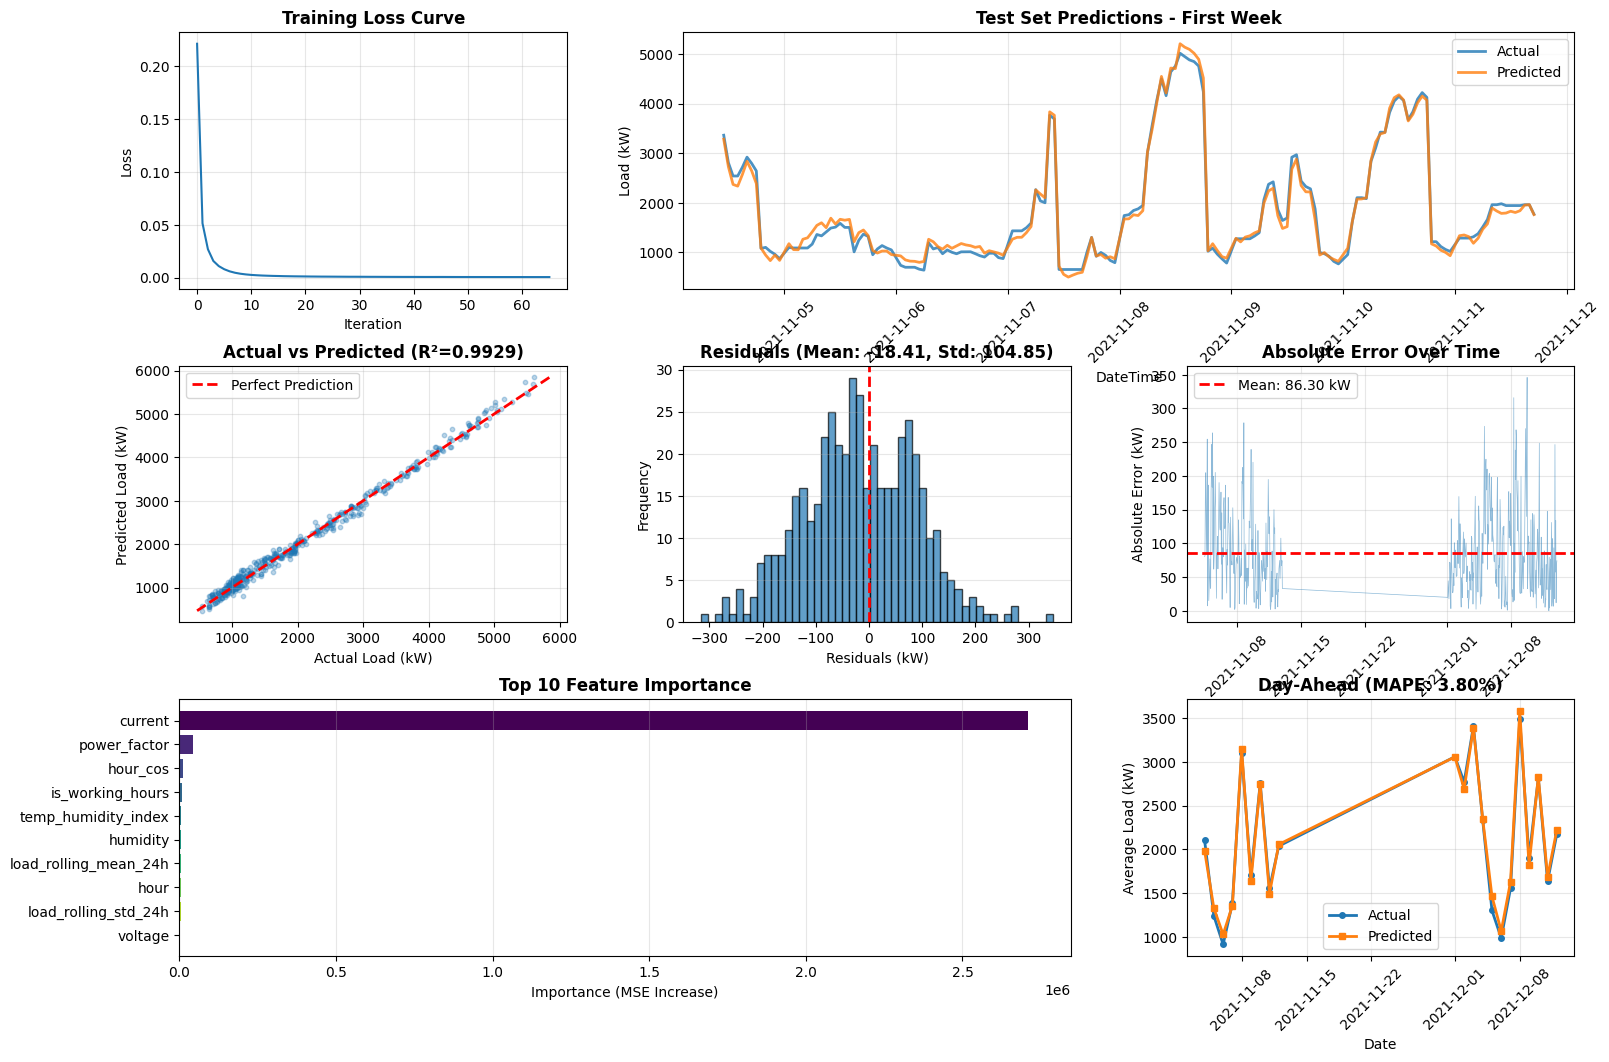


STEP 11: Detailed Error Analysis

Error Statistics by Hour of Day:
            mean        std         max
hour                                   
1     109.140848  79.663850  273.614241
2      67.792434  45.696135  148.930054
3      68.906759  43.153795  134.945740
4      74.934987  59.435695  215.251240
5      77.548520  58.387009  224.856975
6      88.645958  87.471694  316.005123
7      74.533128  56.359115  183.361418
8      84.026911  62.675577  263.831741
9      60.525286  42.131033  131.011620
10    106.126475  62.733066  238.246679
11     91.198284  57.834618  197.747433
12     92.019654  65.209379  268.361010
13    109.287124  88.813411  270.208598
14     97.181311  72.032007  208.500990
15     94.600561  64.363847  212.607895
16     94.363614  64.719584  266.962602
17     95.945309  78.874240  346.092383
18    112.436459  84.111079  278.816173
19     71.577195  50.416339  198.238247
20     87.874081  38.175803  168.830264
21     74.091698  40.401599  186.451483
22     76.58

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MLP NEURAL NETWORK - SHORT-TERM LOAD FORECASTING")
print("="*70)

# ============================================
# STEP 1: LOAD PREPARED DATA
# ============================================
print("\nSTEP 1: Loading Prepared Data...")

# Load scaled data
X_train = np.load('X_train_standard.npy')
y_train = np.load('y_train_standard.npy')

X_val = np.load('X_val_standard.npy')
y_val = np.load('y_val_standard.npy')

X_test = np.load('X_test_standard.npy')
y_test = np.load('y_test_standard.npy')

# Load scalers for inverse transform
with open('y_scaler_standard.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

# Load feature names
with open('feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

# Load original data for timestamps
train_data = pd.read_csv('train_data.csv', index_col='datetime', parse_dates=True)
val_data = pd.read_csv('val_data.csv', index_col='datetime', parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col='datetime', parse_dates=True)

print(f"✓ Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")
print(f"✓ Validation samples: {X_val.shape[0]}")
print(f"✓ Test samples: {X_test.shape[0]}")
print(f"✓ Feature names loaded: {len(feature_names)} features")

# ============================================
# STEP 2: MLP ARCHITECTURE DESIGN
# ============================================
print("\n" + "="*70)
print("STEP 2: MLP Architecture Design")
print("="*70)

print("\nNeural Network Configuration:")
print("  Input Layer: {} neurons (features)".format(X_train.shape[1]))
print("  Hidden Layer 1: 128 neurons, ReLU activation")
print("  Hidden Layer 2: 64 neurons, ReLU activation")
print("  Output Layer: 1 neuron (load prediction)")
print("  Optimizer: Adam")
print("  Early Stopping: Enabled (patience=20)")

# ============================================
# STEP 3: HYPERPARAMETER TUNING
# ============================================
print("\n" + "="*70)
print("STEP 3: Hyperparameter Tuning")
print("="*70)

print("\nTrying different MLP configurations...")

configs = [
    {'hidden_layers': (64,), 'alpha': 0.001, 'name': 'Small (64)'},
    {'hidden_layers': (128, 64), 'alpha': 0.001, 'name': 'Medium (128, 64)'},
    {'hidden_layers': (256, 128), 'alpha': 0.001, 'name': 'Large (256, 128)'},
    {'hidden_layers': (128, 64, 32), 'alpha': 0.001, 'name': 'Deep (128, 64, 32)'},
    {'hidden_layers': (128, 64), 'alpha': 0.0001, 'name': 'Medium + Low Reg'},
]

best_val_rmse = np.inf
best_config = None
results_list = []

for i, config in enumerate(configs):
    print(f"\n[{i+1}/{len(configs)}] Testing: {config['name']}...")

    mlp = MLPRegressor(
        hidden_layer_sizes=config['hidden_layers'],
        activation='relu',
        solver='adam',
        alpha=config['alpha'],
        batch_size='auto',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42,
        verbose=False
    )

    # Train
    mlp.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred_scaled = mlp.predict(X_val)

    # Inverse transform to original scale
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
    y_val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    # Calculate metrics
    val_rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
    val_mae = mean_absolute_error(y_val_actual, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val_actual, y_val_pred) * 100

    results_list.append({
        'Configuration': config['name'],
        'RMSE': val_rmse,
        'MAE': val_mae,
        'MAPE': val_mape,
        'Iterations': mlp.n_iter_
    })

    print(f"  RMSE: {val_rmse:.2f} kW, MAE: {val_mae:.2f} kW, MAPE: {val_mape:.2f}%")
    print(f"  Converged in {mlp.n_iter_} iterations")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_config = config

print(f"\n✓ Best Configuration: {best_config['name']}")
print(f"  Validation RMSE: {best_val_rmse:.2f} kW")

# Show results table
results_df = pd.DataFrame(results_list)
print(f"\n{results_df.to_string(index=False)}")

# ============================================
# STEP 4: TRAIN FINAL MLP MODEL
# ============================================
print("\n" + "="*70)
print("STEP 4: Training Final MLP Model")
print("="*70)

print(f"\nTraining MLP with best configuration: {best_config['name']}...")

final_mlp = MLPRegressor(
    hidden_layer_sizes=best_config['hidden_layers'],
    activation='relu',
    solver='adam',
    alpha=best_config['alpha'],
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,
    random_state=42,
    verbose=True
)

# Train on full training data
final_mlp.fit(X_train, y_train)

print(f"\n✓ Training completed in {final_mlp.n_iter_} iterations")
print(f"  Final training loss: {final_mlp.loss_:.6f}")

# Save the model
with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(final_mlp, f)
print("✓ Model saved: mlp_model.pkl")

# ============================================
# STEP 5: PREDICTIONS
# ============================================
print("\n" + "="*70)
print("STEP 5: Making Predictions")
print("="*70)

# 1. Training predictions
print("\n1. Training set predictions...")
y_train_pred_scaled = final_mlp.predict(X_train)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_train_actual = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# 2. Validation predictions
print("2. Validation set predictions...")
y_val_pred_scaled = final_mlp.predict(X_val)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# 3. Test predictions
print("3. Test set predictions...")
y_test_pred_scaled = final_mlp.predict(X_test)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("✓ All predictions completed")

# ============================================
# STEP 6: EVALUATION METRICS
# ============================================
print("\n" + "="*70)
print("STEP 6: Model Evaluation")
print("="*70)

def calculate_metrics(y_true, y_pred, name):
    """Calculate comprehensive metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    # R² score
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f} kW")
    print(f"  MAE:  {mae:.2f} kW")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

train_metrics = calculate_metrics(y_train_actual, y_train_pred, "Training Set")
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "Validation Set")
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test Set")

# ============================================
# STEP 7: FEATURE IMPORTANCE ANALYSIS
# ============================================
print("\n" + "="*70)
print("STEP 7: Feature Importance Analysis")
print("="*70)

# Calculate feature importance using permutation-based approach
print("\nCalculating feature importance (this may take a moment)...")

baseline_score = mean_squared_error(y_val_actual, y_val_pred)
importances = []

for i, feature in enumerate(feature_names):
    # Permute feature
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])

    # Predict with permuted feature
    y_pred_permuted = final_mlp.predict(X_val_permuted)
    y_pred_permuted = y_scaler.inverse_transform(y_pred_permuted.reshape(-1, 1)).flatten()

    # Calculate score drop
    permuted_score = mean_squared_error(y_val_actual, y_pred_permuted)
    importance = permuted_score - baseline_score
    importances.append(importance)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

# ============================================
# STEP 8: DAY-AHEAD PREDICTIONS
# ============================================
print("\n" + "="*70)
print("STEP 8: Day-Ahead Average Predictions")
print("="*70)

# Resample predictions to daily averages
test_daily_actual = pd.Series(y_test_actual, index=test_data.index).resample('D').mean()
test_daily_pred = pd.Series(y_test_pred, index=test_data.index).resample('D').mean()

# --- FIX: Drop rows where EITHER the actual or predicted daily average is NaN ---
# This ensures that both arrays passed to the metrics function have the same length and no NaNs.
daily_comparison_df = pd.DataFrame({
    'actual': test_daily_actual,
    'predicted': test_daily_pred
}).dropna()

test_daily_actual_clean = daily_comparison_df['actual'].values
test_daily_pred_clean = daily_comparison_df['predicted'].values


# Calculate daily metrics using the clean arrays
daily_rmse = np.sqrt(mean_squared_error(test_daily_actual_clean, test_daily_pred_clean))
daily_mae = mean_absolute_error(test_daily_actual_clean, test_daily_pred_clean)
daily_mape = mean_absolute_percentage_error(test_daily_actual_clean, test_daily_pred_clean) * 100

print(f"\nDay-Ahead Average Metrics:")
print(f"  RMSE: {daily_rmse:.2f} kW")
print(f"  MAE:  {daily_mae:.2f} kW")
print(f"  MAPE: {daily_mape:.2f}%")

# NOTE: You will need to use 'daily_comparison_df' in Step 9 and 10 to ensure consistency.

# ============================================
# STEP 9: SAVE RESULTS
# ============================================
print("\n" + "="*70)
print("STEP 9: Saving Results")
print("="*70)

# Save hourly predictions
hourly_results = pd.DataFrame({
    'actual': y_test_actual,
    'predicted': y_test_pred,
    'error': y_test_actual - y_test_pred,
    'abs_error': np.abs(y_test_actual - y_test_pred)
}, index=test_data.index)
hourly_results.to_csv('mlp_hourly_predictions.csv')
print("✓ Saved: mlp_hourly_predictions.csv")

# Save daily predictions
# ... (Part of Step 9: Save daily predictions)

# Save daily predictions (using the clean DataFrame)
daily_results = daily_comparison_df.copy()
daily_results.to_csv('mlp_daily_predictions.csv')
print("✓ Saved: mlp_daily_predictions.csv")

# Save metrics summary (using the clean daily metrics)
metrics_summary = pd.DataFrame({
    # ... (other metrics)
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE'], daily_rmse],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE'], daily_mae],
    'MAPE': [train_metrics['MAPE'], val_metrics['MAPE'], test_metrics['MAPE'], daily_mape]
})
# ...
metrics_summary.to_csv('mlp_metrics.csv', index=False)
print("✓ Saved: mlp_metrics.csv")

# Save feature importance
feature_importance_df.to_csv('mlp_feature_importance.csv', index=False)
print("✓ Saved: mlp_feature_importance.csv")

# ============================================
# STEP 10: VISUALIZATION
# ============================================
print("\n" + "="*70)
print("STEP 10: Generating Visualizations")
print("="*70)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training Loss Curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(final_mlp.loss_curve_)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Test Predictions - First Week
ax2 = fig.add_subplot(gs[0, 1:])
week_data = test_data.index[:168]
ax2.plot(week_data, y_test_actual[:168], label='Actual', linewidth=2, alpha=0.8)
ax2.plot(week_data, y_test_pred[:168], label='Predicted', linewidth=2, alpha=0.8)
ax2.set_xlabel('DateTime')
ax2.set_ylabel('Load (kW)')
ax2.set_title('Test Set Predictions - First Week', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Actual vs Predicted Scatter
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test_actual, y_test_pred, alpha=0.3, s=10)
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Load (kW)')
ax3.set_ylabel('Predicted Load (kW)')
ax3.set_title(f'Actual vs Predicted (R²={test_metrics["R2"]:.4f})', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals Distribution
ax4 = fig.add_subplot(gs[1, 1])
residuals = y_test_actual - y_test_pred
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuals (kW)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Residuals (Mean: {residuals.mean():.2f}, Std: {residuals.std():.2f})', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Error Over Time
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(test_data.index, np.abs(residuals), alpha=0.5, linewidth=0.5)
ax5.axhline(np.abs(residuals).mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.abs(residuals).mean():.2f} kW')
ax5.set_xlabel('DateTime')
ax5.set_ylabel('Absolute Error (kW)')
ax5.set_title('Absolute Error Over Time', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Feature Importance (Top 10)
ax6 = fig.add_subplot(gs[2, :2])
top_10 = feature_importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))
ax6.barh(range(len(top_10)), top_10['Importance'], color=colors)
ax6.set_yticks(range(len(top_10)))
ax6.set_yticklabels(top_10['Feature'])
ax6.set_xlabel('Importance (MSE Increase)')
ax6.set_title('Top 10 Feature Importance', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')
ax6.invert_yaxis()

# Plot 7: Day-Ahead Predictions
# ... (Part of Step 10: Visualization)

# Plot 7: Day-Ahead Predictions
ax7 = fig.add_subplot(gs[2, 2])
ax7.plot(daily_comparison_df.index, daily_comparison_df['actual'].values,
          marker='o', label='Actual', linewidth=2, markersize=4)
ax7.plot(daily_comparison_df.index, daily_comparison_df['predicted'].values,
          marker='s', label='Predicted', linewidth=2, markersize=4)
# ...
ax7.set_xlabel('Date')
ax7.set_ylabel('Average Load (kW)')
ax7.set_title(f'Day-Ahead (MAPE: {daily_mape:.2f}%)', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

plt.savefig('mlp_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: mlp_results.png")
plt.show()

# ============================================
# STEP 11: ERROR ANALYSIS
# ============================================
print("\n" + "="*70)
print("STEP 11: Detailed Error Analysis")
print("="*70)

# Hour-wise error analysis
hourly_errors = pd.DataFrame({
    'hour': test_data.index.hour,
    'error': np.abs(residuals)
})
hourly_error_stats = hourly_errors.groupby('hour')['error'].agg(['mean', 'std', 'max'])

print("\nError Statistics by Hour of Day:")
print(hourly_error_stats.to_string())

# Day of week error analysis
dow_errors = pd.DataFrame({
    'day_of_week': test_data.index.dayofweek,
    'error': np.abs(residuals)
})
dow_error_stats = dow_errors.groupby('day_of_week')['error'].agg(['mean', 'std'])
dow_error_stats.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

print("\nError Statistics by Day of Week:")
print(dow_error_stats.to_string())

# Percentile analysis
print("\nError Percentiles:")
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(np.abs(residuals), p)
    print(f"  {p}th percentile: {val:.2f} kW")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*70)
print("MLP MODEL SUMMARY")
print("="*70)
print(f"\nArchitecture: {best_config['hidden_layers']}")
print(f"Total Parameters: ~{sum([X_train.shape[1] * best_config['hidden_layers'][0]] +
      [best_config['hidden_layers'][i] * best_config['hidden_layers'][i+1]
       for i in range(len(best_config['hidden_layers'])-1)] +
      [best_config['hidden_layers'][-1]])}")
print(f"Training Iterations: {final_mlp.n_iter_}")

print(f"\nTest Set Performance (Hourly):")
print(f"  RMSE: {test_metrics['RMSE']:.2f} kW")
print(f"  MAE:  {test_metrics['MAE']:.2f} kW")
print(f"  MAPE: {test_metrics['MAPE']:.2f}%")
print(f"  R²:   {test_metrics['R2']:.4f}")

print(f"\nTest Set Performance (Day-Ahead):")
print(f"  RMSE: {daily_rmse:.2f} kW")
print(f"  MAE:  {daily_mae:.2f} kW")
print(f"  MAPE: {daily_mape:.2f}%")

print(f"\nTop 3 Most Important Features:")
for i, row in feature_importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}")

print("\n" + "="*70)
print("MLP MODEL COMPLETE!")
print("="*70)

# **ANFIS Model**

ANFIS MODEL - ADVANCED SHORT-TERM LOAD FORECASTING

STEP 1: Loading Prepared Data...
✓ Training samples: 2200, Features: 22
✓ Validation samples: 471
✓ Test samples: 473

STEP 2: Feature Selection for ANFIS

Selected 8 most important features:
  1. current: 0.9922
  2. load_lag_1h: 0.9085
  3. hour_cos: 0.5668
  4. load_lag_24h: 0.4952
  5. load_rolling_mean_24h: 0.4738
  6. is_working_hours: 0.4539
  7. humidity: 0.4373
  8. temp_humidity_index: 0.4107

ANFIS input shape: (2200, 8)

STEP 3: ANFIS Hyperparameter Tuning

Testing different membership function configurations...

[Testing] 2 membership functions per input...
  Total fuzzy rules: 256
  RMSE: 128.88 kW, MAE: 100.57 kW, MAPE: 5.41%

[Testing] 3 membership functions per input...
  Total fuzzy rules: 6561
  ⚠ Too many rules (6561), skipping...

[Testing] 4 membership functions per input...
  Total fuzzy rules: 65536
  ⚠ Too many rules (65536), skipping...

✓ Best configuration: 2 membership functions
  Validation RMSE: 128.88 k

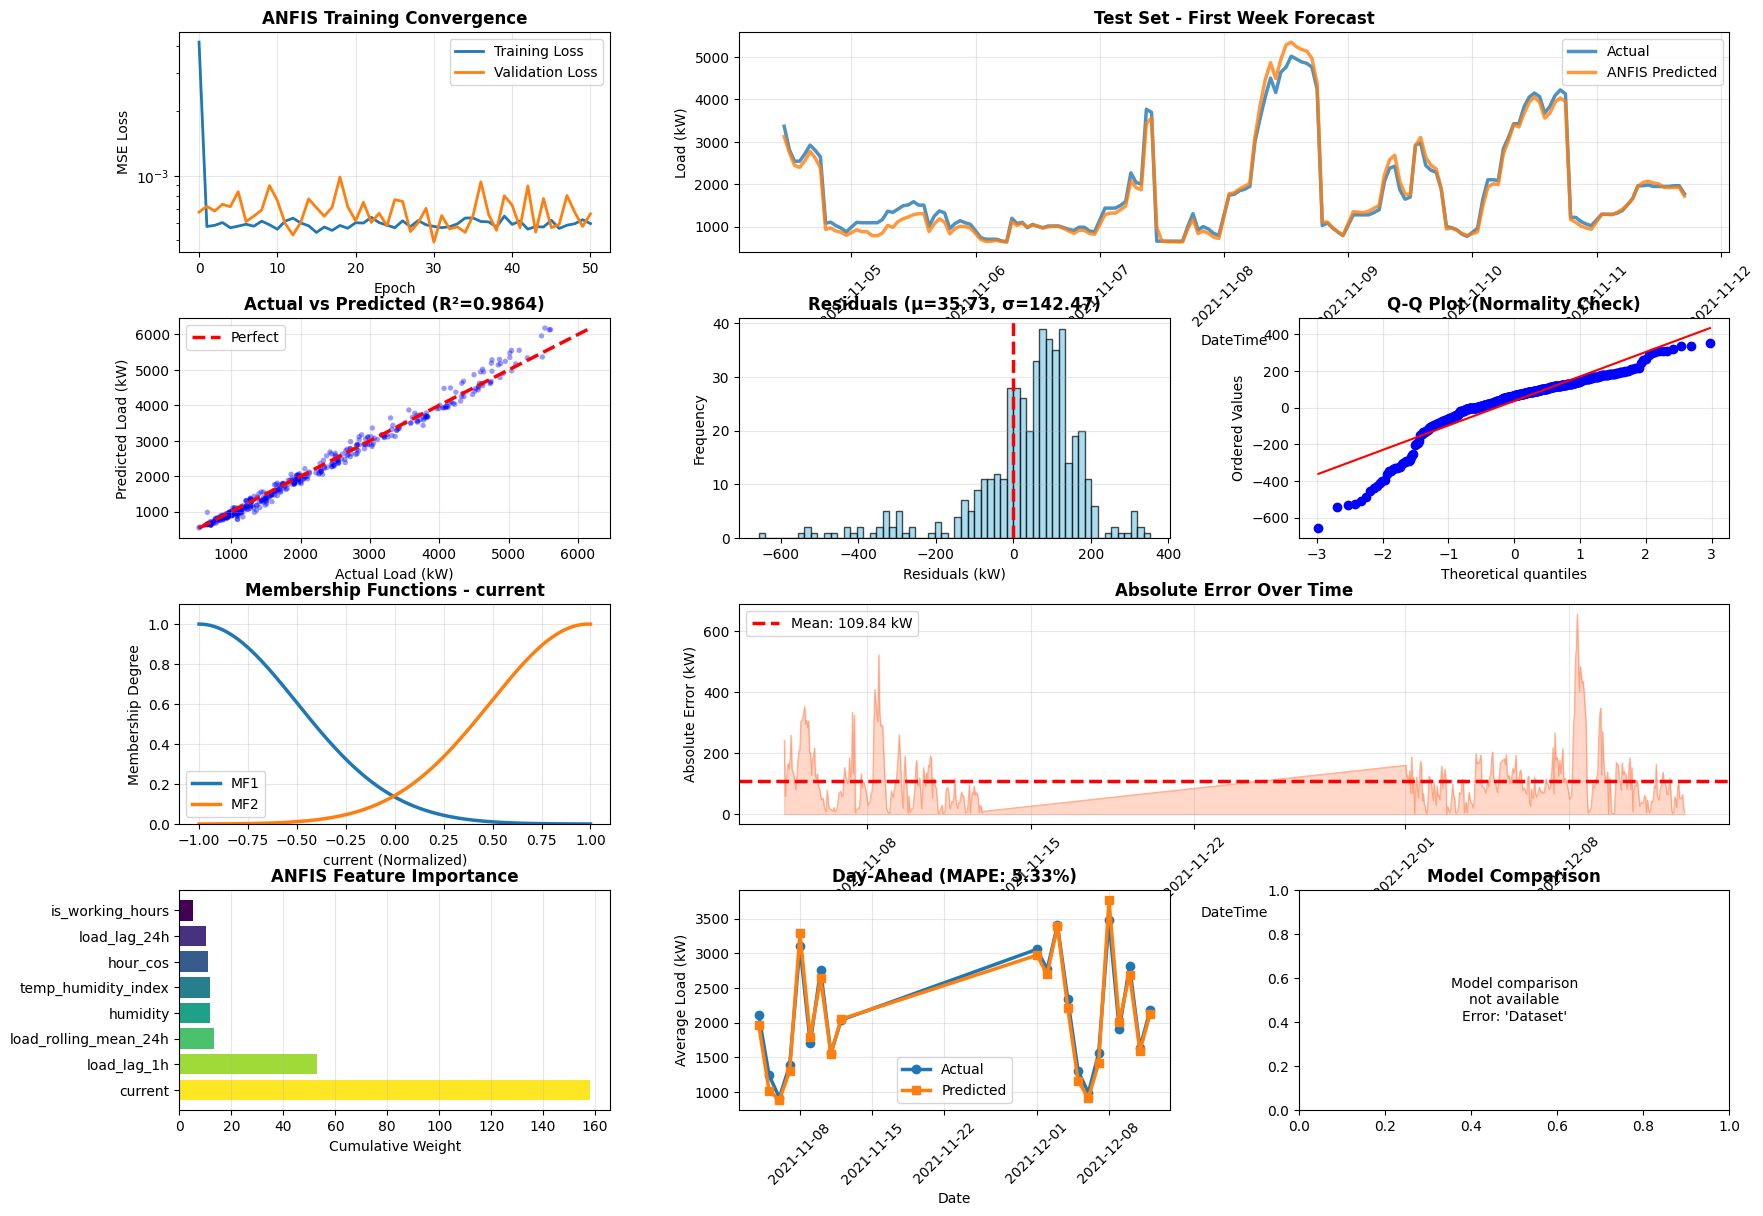


STEP 11: Detailed Error Analysis

Error Statistics by Hour of Day:
            mean         std         max
hour                                    
1     101.136575   54.845736  198.428807
2      97.033265   54.377977  209.500988
3     100.022338   55.195779  211.628180
4      95.310119   67.554851  303.913698
5     102.271390   83.640974  307.843424
6     115.558020   91.974021  331.547090
7     148.239422  124.260805  508.849714
8     152.976274  149.971070  544.165776
9     168.732747  160.377155  656.910560
10    136.030355  133.967668  531.186969
11    144.606895  115.806082  401.801971
12    127.061758  143.743605  523.241399
13    115.547574  109.691467  457.236688
14    117.932922   97.826223  427.494418
15    124.669939  101.284849  436.176696
16    123.396694   90.689124  394.755241
17    125.788908   79.959068  347.069787
18    129.183075   82.470593  296.287562
19     74.094491   35.859949  146.944496
20     63.302804   44.030761  137.024668
21     61.558322   45.157578  

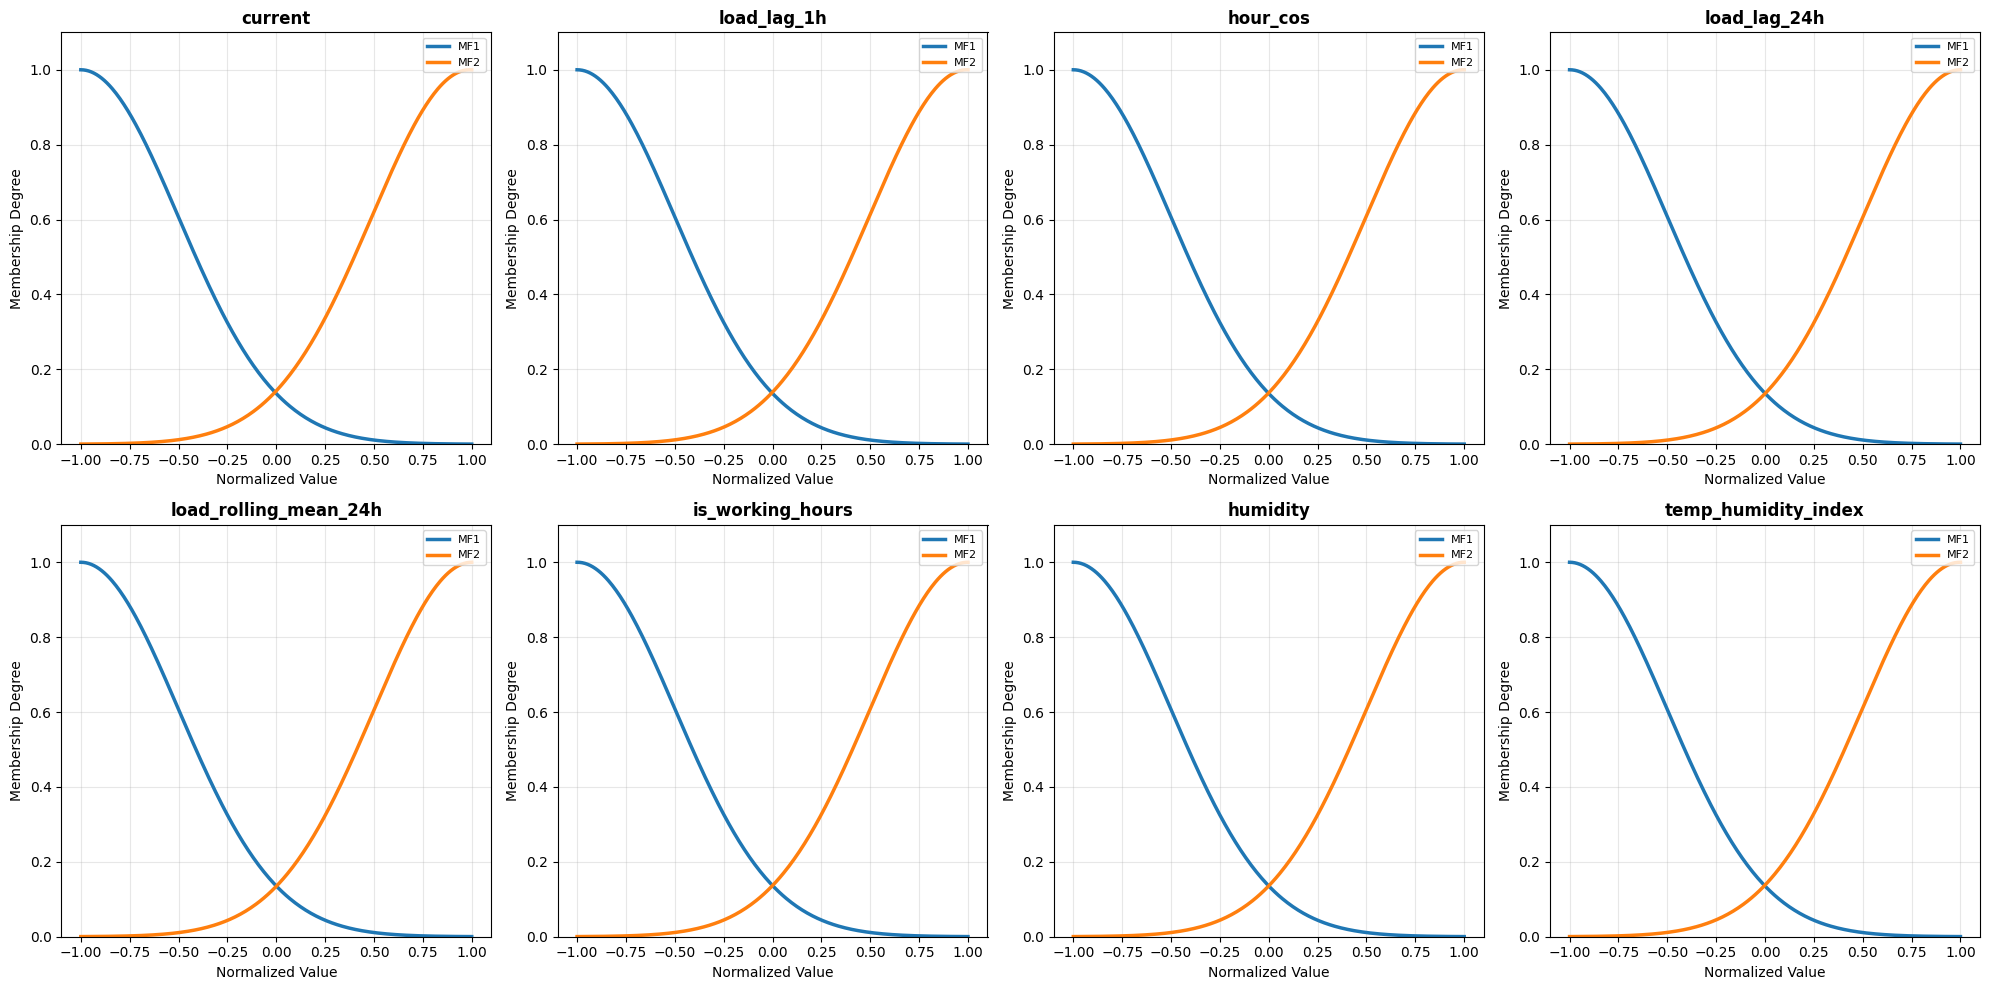


STEP 13: Rule Activation Analysis

Top 10 Most Active Rules (out of 256):
 Rule_ID  Avg_Activation
     255        0.314363
     251        0.130582
     223        0.084971
     239        0.045769
     127        0.044640
     191        0.042012
     235        0.030413
     123        0.029989
     247        0.029773
     187        0.028892
✓ Saved: anfis_rule_activation.png


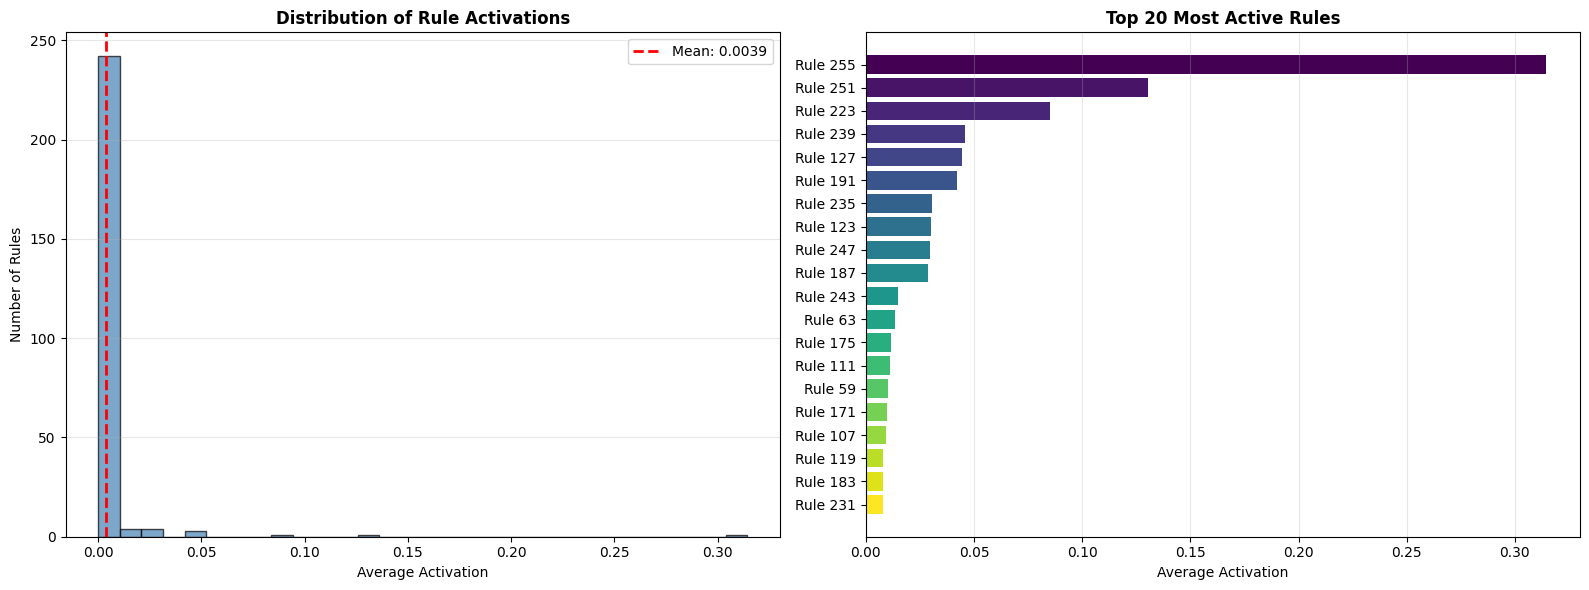

✓ Saved: anfis_rule_activation.csv

ANFIS MODEL - FINAL SUMMARY

Architecture:
  Input Features: 8
  Membership Functions per Input: 2
  Total Fuzzy Rules: 256
  Active Rules (>1% avg activation): 15

Selected Features:
  1. current
  2. load_lag_1h
  3. hour_cos
  4. load_lag_24h
  5. load_rolling_mean_24h
  6. is_working_hours
  7. humidity
  8. temp_humidity_index

Test Set Performance (Hourly):
  RMSE: 146.88 kW
  MAE:  109.84 kW
  MAPE: 5.91%
  R²:   0.9864

Test Set Performance (Day-Ahead):
  RMSE: 122.77 kW
  MAE:  101.92 kW
  MAPE: 5.33%

Model Interpretability:
  Total Rules Extracted: 256
  High-Impact Rules (weight > median): 128

FILES CREATED:
  1. anfis_model.pkl - Trained ANFIS model
  2. anfis_selected_features.pkl - Feature selection info
  3. anfis_hourly_predictions.csv - Hourly forecasts
  4. anfis_daily_predictions.csv - Daily forecasts
  5. anfis_metrics.csv - Performance metrics
  6. anfis_fuzzy_rules.csv - Extracted fuzzy rules
  7. anfis_rule_activation.csv - R

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.optimize import minimize
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ANFIS MODEL - ADVANCED SHORT-TERM LOAD FORECASTING")
print("="*70)

# ============================================
# ANFIS CLASS IMPLEMENTATION
# ============================================

class ANFIS:
    """
    Adaptive Neuro-Fuzzy Inference System (ANFIS)

    Architecture:
    - Layer 1: Fuzzification (Gaussian membership functions)
    - Layer 2: Fuzzy Rule Firing Strengths
    - Layer 3: Normalization
    - Layer 4: Consequent Parameters (TSK model)
    - Layer 5: Defuzzification (Output)
    """

    def __init__(self, n_inputs, n_mfs=3, learning_rate=0.01):
        """
        Initialize ANFIS

        Parameters:
        -----------
        n_inputs : int
            Number of input features
        n_mfs : int
            Number of membership functions per input (default: 3)
        learning_rate : float
            Learning rate for gradient descent (default: 0.01)
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.n_rules = n_mfs ** n_inputs  # Total fuzzy rules
        self.learning_rate = learning_rate

        # Initialize parameters
        self._initialize_parameters()

        # Training history
        self.train_losses = []
        self.val_losses = []

    def _initialize_parameters(self):
        """Initialize membership function parameters and consequent parameters"""

        # Premise parameters (Gaussian MF: mean and std)
        # Shape: (n_inputs, n_mfs, 2) - last dim: [mean, std]
        self.premise_params = np.random.randn(self.n_inputs, self.n_mfs, 2) * 0.5

        # Initialize means uniformly across input range
        for i in range(self.n_inputs):
            self.premise_params[i, :, 0] = np.linspace(-1, 1, self.n_mfs)
            self.premise_params[i, :, 1] = np.ones(self.n_mfs) * 0.5  # Initial std

        # Consequent parameters (TSK model: linear functions)
        # Shape: (n_rules, n_inputs + 1) - last column is bias
        self.consequent_params = np.random.randn(self.n_rules, self.n_inputs + 1) * 0.1

    def _gaussian_mf(self, x, mean, std):
        """
        Gaussian membership function

        μ(x) = exp(-(x - mean)² / (2 * std²))
        """
        return np.exp(-0.5 * ((x - mean) / (std + 1e-10)) ** 2)

    def _fuzzification(self, X):
        """
        Layer 1: Fuzzification
        Convert crisp inputs to fuzzy membership degrees

        Returns: membership_matrix shape (n_samples, n_inputs, n_mfs)
        """
        n_samples = X.shape[0]
        membership = np.zeros((n_samples, self.n_inputs, self.n_mfs))

        for i in range(self.n_inputs):
            for j in range(self.n_mfs):
                mean = self.premise_params[i, j, 0]
                std = np.abs(self.premise_params[i, j, 1]) + 1e-10
                membership[:, i, j] = self._gaussian_mf(X[:, i], mean, std)

        return membership

    def _rule_firing(self, membership):
        """
        Layer 2: Calculate firing strength of each rule
        Using product T-norm (AND operation)

        Returns: firing_strengths shape (n_samples, n_rules)
        """
        n_samples = membership.shape[0]
        firing_strengths = np.ones((n_samples, self.n_rules))

        # Generate all combinations of membership functions (rules)
        rule_idx = 0
        indices = np.ndindex(*[self.n_mfs] * self.n_inputs)

        for combo in indices:
            rule_strength = np.ones(n_samples)
            for input_idx, mf_idx in enumerate(combo):
                rule_strength *= membership[:, input_idx, mf_idx]
            firing_strengths[:, rule_idx] = rule_strength
            rule_idx += 1

        return firing_strengths

    def _normalization(self, firing_strengths):
        """
        Layer 3: Normalize firing strengths

        w̄ᵢ = wᵢ / Σwⱼ
        """
        sum_strengths = np.sum(firing_strengths, axis=1, keepdims=True) + 1e-10
        normalized = firing_strengths / sum_strengths
        return normalized

    def _consequent(self, X, normalized_strengths):
        """
        Layer 4: Apply consequent parameters (TSK model)

        fᵢ = w̄ᵢ * (p₀ + p₁x₁ + ... + pₙxₙ)
        """
        n_samples = X.shape[0]

        # Add bias term to input
        X_bias = np.hstack([X, np.ones((n_samples, 1))])

        # Calculate linear consequent for each rule
        consequents = np.zeros((n_samples, self.n_rules))
        for i in range(self.n_rules):
            consequents[:, i] = np.dot(X_bias, self.consequent_params[i])

        # Weight by normalized firing strengths
        weighted_consequents = normalized_strengths * consequents

        return weighted_consequents

    def _defuzzification(self, weighted_consequents):
        """
        Layer 5: Defuzzification (output)

        y = Σ(w̄ᵢ * fᵢ)
        """
        return np.sum(weighted_consequents, axis=1)

    def forward(self, X):
        """
        Forward pass through ANFIS

        Returns: predictions and intermediate values for backpropagation
        """
        # Layer 1: Fuzzification
        membership = self._fuzzification(X)

        # Layer 2: Rule firing
        firing_strengths = self._rule_firing(membership)

        # Layer 3: Normalization
        normalized_strengths = self._normalization(firing_strengths)

        # Layer 4: Consequent
        weighted_consequents = self._consequent(X, normalized_strengths)

        # Layer 5: Output
        output = self._defuzzification(weighted_consequents)

        # Store intermediate values for backprop
        cache = {
            'membership': membership,
            'firing_strengths': firing_strengths,
            'normalized_strengths': normalized_strengths,
            'weighted_consequents': weighted_consequents
        }

        return output, cache

    def predict(self, X):
        """Make predictions"""
        output, _ = self.forward(X)
        return output

    def _compute_loss(self, y_true, y_pred):
        """Mean Squared Error loss"""
        return np.mean((y_true - y_pred) ** 2)

    def _update_consequent_params(self, X, y, normalized_strengths):
        """
        Update consequent parameters using least squares
        (More stable than gradient descent for these params)
        """
        n_samples = X.shape[0]
        X_bias = np.hstack([X, np.ones((n_samples, 1))])

        # For each rule, solve weighted least squares
        for i in range(self.n_rules):
            # Weight matrix for this rule
            W = np.diag(normalized_strengths[:, i])

            # Weighted least squares: (X'WX)⁻¹X'Wy
            try:
                XtWX = X_bias.T @ W @ X_bias + 1e-6 * np.eye(self.n_inputs + 1)
                XtWy = X_bias.T @ W @ y
                self.consequent_params[i] = np.linalg.solve(XtWX, XtWy)
            except:
                # If singular, use gradient descent
                error = y - normalized_strengths[:, i] * (X_bias @ self.consequent_params[i])
                gradient = -2 * X_bias.T @ (normalized_strengths[:, i] * error) / n_samples
                self.consequent_params[i] -= self.learning_rate * gradient

    def _update_premise_params(self, X, y, membership, firing_strengths,
                                normalized_strengths, output):
        """
        Update premise parameters (membership function params) using gradient descent
        """
        n_samples = X.shape[0]
        error = output - y

        # Gradient for each input's membership functions
        for i in range(self.n_inputs):
            for j in range(self.n_mfs):
                # Find rules that use this MF
                mf_pattern = np.zeros(self.n_inputs, dtype=int)
                grad_mean = 0
                grad_std = 0

                rule_idx = 0
                for combo in np.ndindex(*[self.n_mfs] * self.n_inputs):
                    if combo[i] == j:
                        # This rule uses MF j for input i
                        # Compute gradient contribution

                        # Get consequent output for this rule
                        X_bias = np.hstack([X, np.ones((n_samples, 1))])
                        rule_consequent = X_bias @ self.consequent_params[rule_idx]

                        # Compute partial derivatives
                        mean = self.premise_params[i, j, 0]
                        std = np.abs(self.premise_params[i, j, 1]) + 1e-10

                        # ∂μ/∂mean
                        dmf_dmean = membership[:, i, j] * (X[:, i] - mean) / (std ** 2)

                        # ∂μ/∂std
                        dmf_dstd = membership[:, i, j] * ((X[:, i] - mean) ** 2) / (std ** 3)

                        # Chain rule through network
                        dout_drule = rule_consequent * normalized_strengths[:, rule_idx]

                        grad_mean += np.sum(2 * error * dout_drule * dmf_dmean) / n_samples
                        grad_std += np.sum(2 * error * dout_drule * dmf_dstd) / n_samples

                    rule_idx += 1

                # Update parameters
                self.premise_params[i, j, 0] -= self.learning_rate * grad_mean
                self.premise_params[i, j, 1] -= self.learning_rate * grad_std * 0.1  # Smaller LR for std

                # Keep std positive
                self.premise_params[i, j, 1] = np.abs(self.premise_params[i, j, 1])

    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=100,
            batch_size=32, verbose=True, patience=15):
        """
        Train ANFIS model

        Parameters:
        -----------
        X_train : array-like, shape (n_samples, n_features)
            Training input data
        y_train : array-like, shape (n_samples,)
            Training target data
        X_val : array-like, optional
            Validation input data
        y_val : array-like, optional
            Validation target data
        epochs : int
            Number of training epochs
        batch_size : int
            Mini-batch size
        verbose : bool
            Print training progress
        patience : int
            Early stopping patience
        """
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size

        best_val_loss = np.inf
        patience_counter = 0

        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            epoch_loss = 0

            # Mini-batch training
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = start_idx + batch_size

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                output, cache = self.forward(X_batch)

                # Compute loss
                loss = self._compute_loss(y_batch, output)
                epoch_loss += loss

                # Backward pass - Update consequent parameters (stable method)
                self._update_consequent_params(X_batch, y_batch,
                                              cache['normalized_strengths'])

                # Update premise parameters (gradient descent)
                self._update_premise_params(X_batch, y_batch,
                                           cache['membership'],
                                           cache['firing_strengths'],
                                           cache['normalized_strengths'],
                                           output)

            # Average epoch loss
            epoch_loss /= n_batches
            self.train_losses.append(epoch_loss)

            # Validation
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_loss = self._compute_loss(y_val, val_pred)
                self.val_losses.append(val_loss)

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    self.best_params = {
                        'premise': self.premise_params.copy(),
                        'consequent': self.consequent_params.copy()
                    }
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    if verbose:
                        print(f"\nEarly stopping at epoch {epoch+1}")
                    # Restore best parameters
                    self.premise_params = self.best_params['premise']
                    self.consequent_params = self.best_params['consequent']
                    break

                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - "
                          f"Train Loss: {epoch_loss:.6f}, "
                          f"Val Loss: {val_loss:.6f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.6f}")

    def extract_rules(self, feature_names=None):
        """
        Extract interpretable fuzzy rules from trained ANFIS

        Returns:
        --------
        rules : list of dict
            Each dict contains rule information
        """
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(self.n_inputs)]

        # Define linguistic terms
        linguistic_terms = ['LOW', 'MEDIUM', 'HIGH']
        if self.n_mfs == 5:
            linguistic_terms = ['VERY_LOW', 'LOW', 'MEDIUM', 'HIGH', 'VERY_HIGH']
        elif self.n_mfs == 2:
            linguistic_terms = ['LOW', 'HIGH']

        rules = []
        rule_idx = 0

        for combo in np.ndindex(*[self.n_mfs] * self.n_inputs):
            # Build rule antecedent
            antecedent = []
            for input_idx, mf_idx in enumerate(combo):
                feature = feature_names[input_idx]
                term = linguistic_terms[mf_idx] if mf_idx < len(linguistic_terms) else f"MF{mf_idx}"
                antecedent.append(f"{feature} is {term}")

            # Get consequent (linear equation)
            params = self.consequent_params[rule_idx]
            consequent_parts = []
            for i, param in enumerate(params[:-1]):
                if abs(param) > 1e-3:  # Only include significant terms
                    consequent_parts.append(f"{param:.4f}*{feature_names[i]}")
            consequent_parts.append(f"{params[-1]:.4f}")  # Bias

            consequent = " + ".join(consequent_parts)

            rules.append({
                'rule_id': rule_idx,
                'antecedent': " AND ".join(antecedent),
                'consequent': consequent,
                'weight': np.abs(params).sum()  # Rule importance
            })

            rule_idx += 1

        # Sort rules by importance
        rules = sorted(rules, key=lambda x: x['weight'], reverse=True)

        return rules


# ============================================
# STEP 1: LOAD DATA
# ============================================
print("\nSTEP 1: Loading Prepared Data...")

X_train = np.load('X_train_minmax.npy')
y_train = np.load('y_train_minmax.npy')

X_val = np.load('X_val_minmax.npy')
y_val = np.load('y_val_minmax.npy')

X_test = np.load('X_test_minmax.npy')
y_test = np.load('y_test_minmax.npy')

# Load scaler for inverse transform
with open('y_scaler_minmax.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

# Load feature names
with open('feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"✓ Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")
print(f"✓ Validation samples: {X_val.shape[0]}")
print(f"✓ Test samples: {X_test.shape[0]}")

# ============================================
# STEP 2: FEATURE SELECTION FOR ANFIS
# ============================================
print("\n" + "="*70)
print("STEP 2: Feature Selection for ANFIS")
print("="*70)

# ANFIS works best with 5-10 most important features
# Use correlation with target to select features
train_data = pd.read_csv('train_data.csv', index_col='datetime', parse_dates=True)

# Calculate correlations
correlations = {}
for i, feature in enumerate(feature_names):
    if feature in train_data.columns:
        corr = train_data[feature].corr(train_data['load_kw'])
        correlations[feature] = abs(corr)

# Sort and select top features
top_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
selected_features = [f[0] for f in top_features[:8]]  # Top 8 features
selected_indices = [feature_names.index(f) for f in selected_features]

print(f"\nSelected {len(selected_features)} most important features:")
for i, (feature, corr) in enumerate(top_features[:8]):
    print(f"  {i+1}. {feature}: {corr:.4f}")

# Filter data
X_train_anfis = X_train[:, selected_indices]
X_val_anfis = X_val[:, selected_indices]
X_test_anfis = X_test[:, selected_indices]

print(f"\nANFIS input shape: {X_train_anfis.shape}")

# ============================================
# STEP 3: HYPERPARAMETER TUNING
# ============================================
print("\n" + "="*70)
print("STEP 3: ANFIS Hyperparameter Tuning")
print("="*70)

# Try different numbers of membership functions
mf_configs = [2, 3, 4]
best_val_rmse = np.inf
best_n_mfs = None
tuning_results = []

print("\nTesting different membership function configurations...")

for n_mfs in mf_configs:
    print(f"\n[Testing] {n_mfs} membership functions per input...")
    print(f"  Total fuzzy rules: {n_mfs ** len(selected_features)}")

    # Skip if too many rules
    if n_mfs ** len(selected_features) > 512:
        print(f"  ⚠ Too many rules ({n_mfs ** len(selected_features)}), skipping...")
        continue

    # Create and train ANFIS
    anfis = ANFIS(n_inputs=len(selected_features),
                  n_mfs=n_mfs,
                  learning_rate=0.01)

    anfis.fit(X_train_anfis, y_train,
              X_val_anfis, y_val,
              epochs=50,
              batch_size=64,
              verbose=False,
              patience=10)

    # Evaluate
    val_pred = anfis.predict(X_val_anfis)
    val_pred_original = y_scaler.inverse_transform(val_pred.reshape(-1, 1)).flatten()
    val_actual_original = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    val_rmse = np.sqrt(mean_squared_error(val_actual_original, val_pred_original))
    val_mae = mean_absolute_error(val_actual_original, val_pred_original)
    mape_val = mean_absolute_percentage_error(val_actual_original, val_pred_original) * 100


    tuning_results.append({
        'n_mfs': n_mfs,
        'n_rules': n_mfs ** len(selected_features),
        'RMSE': val_rmse,
        'MAE': val_mae,
        'MAPE': mape_val
    })

    print(f"  RMSE: {val_rmse:.2f} kW, MAE: {val_mae:.2f} kW, MAPE: {mape_val:.2f}%")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_n_mfs = n_mfs

print(f"\n✓ Best configuration: {best_n_mfs} membership functions")
print(f"  Validation RMSE: {best_val_rmse:.2f} kW")

# Show tuning results
tuning_df = pd.DataFrame(tuning_results)
print(f"\n{tuning_df.to_string(index=False)}")

# ============================================
# STEP 4: TRAIN FINAL ANFIS MODEL
# ============================================
print("\n" + "="*70)
print("STEP 4: Training Final ANFIS Model")
print("="*70)

print(f"\nConfiguration:")
print(f"  Inputs: {len(selected_features)}")
print(f"  Membership Functions: {best_n_mfs}")
print(f"  Total Rules: {best_n_mfs ** len(selected_features)}")
print(f"  Learning Rate: 0.01")

# Create final model
final_anfis = ANFIS(n_inputs=len(selected_features),
                    n_mfs=best_n_mfs,
                    learning_rate=0.01)

# Train with more epochs
print("\nTraining...")
final_anfis.fit(X_train_anfis, y_train,
                X_val_anfis, y_val,
                epochs=150,
                batch_size=64,
                verbose=True,
                patience=20)

print("\n✓ Training completed")

# Save model
with open('anfis_model.pkl', 'wb') as f:
    pickle.dump(final_anfis, f)
with open('anfis_selected_features.pkl', 'wb') as f:
    pickle.dump({'features': selected_features, 'indices': selected_indices}, f)
print("✓ Model saved")

# ============================================
# STEP 5: MAKE PREDICTIONS
# ============================================
print("\n" + "="*70)
print("STEP 5: Making Predictions")
print("="*70)

# Training predictions
y_train_pred = final_anfis.predict(X_train_anfis)
y_train_pred_original = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_train_actual_original = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Validation predictions
y_val_pred = final_anfis.predict(X_val_anfis)
y_val_pred_original = y_scaler.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
y_val_actual_original = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# Test predictions
y_test_pred = final_anfis.predict(X_test_anfis)
y_test_pred_original = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test_actual_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("✓ All predictions completed")

# ============================================
# STEP 6: EVALUATION METRICS
# ============================================
print("\n" + "="*70)
print("STEP 6: Model Evaluation")
print("="*70)

def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f} kW")
    print(f"  MAE:  {mae:.2f} kW")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

train_metrics = calculate_metrics(y_train_actual_original, y_train_pred_original, "Training Set")
val_metrics = calculate_metrics(y_val_actual_original, y_val_pred_original, "Validation Set")
test_metrics = calculate_metrics(y_test_actual_original, y_test_pred_original, "Test Set")

# ============================================
# STEP 7: EXTRACT FUZZY RULES
# ============================================
print("\n" + "="*70)
print("STEP 7: Extracting Fuzzy Rules")
print("="*70)

rules = final_anfis.extract_rules(selected_features)

print(f"\nTotal fuzzy rules: {len(rules)}")
print(f"\nTop 10 Most Important Rules:\n")
for i, rule in enumerate(rules[:10]):
    print(f"Rule {i+1} (Weight: {rule['weight']:.3f}):")
    print(f"  IF {rule['antecedent']}")
    print(f"  THEN Load = {rule['consequent']}")
    print()

# Save rules to file
rules_df = pd.DataFrame(rules)
rules_df.to_csv('anfis_fuzzy_rules.csv', index=False)
print("✓ Saved: anfis_fuzzy_rules.csv")

# ============================================
# STEP 8: DAY-AHEAD PREDICTIONS
# ============================================
print("\n" + "="*70)
print("STEP 8: Day-Ahead Predictions")
print("="*70)

test_data = pd.read_csv('test_data.csv', index_col='datetime', parse_dates=True)

test_daily_actual = pd.Series(y_test_actual_original, index=test_data.index).resample('D').mean()
test_daily_pred = pd.Series(y_test_pred_original, index=test_data.index).resample('D').mean()

# Remove NaN values
daily_comparison = pd.DataFrame({
    'actual': test_daily_actual,
    'predicted': test_daily_pred
}).dropna()

daily_rmse = np.sqrt(mean_squared_error(daily_comparison['actual'], daily_comparison['predicted']))
daily_mae = mean_absolute_error(daily_comparison['actual'], daily_comparison['predicted'])
daily_mape = mean_absolute_percentage_error(daily_comparison['actual'], daily_comparison['predicted']) * 100

print(f"\nDay-Ahead Metrics:")
print(f"  RMSE: {daily_rmse:.2f} kW")
print(f"  MAE:  {daily_mae:.2f} kW")
print(f"  MAPE: {daily_mape:.2f}%")

# ============================================
# STEP 9: SAVE RESULTS
# ============================================
print("\n" + "="*70)
print("STEP 9: Saving Results")
print("="*70)

# Hourly predictions
hourly_results = pd.DataFrame({
    'actual': y_test_actual_original,
    'predicted': y_test_pred_original,
    'error': y_test_actual_original - y_test_pred_original
}, index=test_data.index)
hourly_results.to_csv('anfis_hourly_predictions.csv')
print("✓ Saved: anfis_hourly_predictions.csv")

# Daily predictions
daily_comparison.to_csv('anfis_daily_predictions.csv')
print("✓ Saved: anfis_daily_predictions.csv")

# Metrics
metrics_summary = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Daily'],
    'RMSE': [train_metrics['RMSE'], val_metrics['RMSE'], test_metrics['RMSE'], daily_rmse],
    'MAE': [train_metrics['MAE'], val_metrics['MAE'], test_metrics['MAE'], daily_mae],
    'MAPE': [train_metrics['MAPE'], val_metrics['MAPE'], test_metrics['MAPE'], daily_mape],
    'R2': [train_metrics['R2'], val_metrics['R2'], test_metrics['R2'], np.nan]
})
metrics_summary.to_csv('anfis_metrics.csv', index=False)
print("✓ Saved: anfis_metrics.csv")

# ============================================
# STEP 10: COMPREHENSIVE VISUALIZATIONS
# ============================================
print("\n" + "="*70)
print("STEP 10: Generating Visualizations")
print("="*70)

# Create comprehensive figure
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training Loss Curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(final_anfis.train_losses, label='Training Loss', linewidth=2)
ax1.plot(final_anfis.val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('ANFIS Training Convergence', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Test Predictions - First Week
ax2 = fig.add_subplot(gs[0, 1:])
week_indices = min(168, len(test_data))
ax2.plot(test_data.index[:week_indices], y_test_actual_original[:week_indices],
         label='Actual', linewidth=2.5, alpha=0.8)
ax2.plot(test_data.index[:week_indices], y_test_pred_original[:week_indices],
         label='ANFIS Predicted', linewidth=2.5, alpha=0.8)
ax2.set_xlabel('DateTime')
ax2.set_ylabel('Load (kW)')
ax2.set_title('Test Set - First Week Forecast', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Actual vs Predicted Scatter
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_test_actual_original, y_test_pred_original, alpha=0.4, s=15, c='blue', edgecolors='none')
min_val = min(y_test_actual_original.min(), y_test_pred_original.min())
max_val = max(y_test_actual_original.max(), y_test_pred_original.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, label='Perfect')
ax3.set_xlabel('Actual Load (kW)')
ax3.set_ylabel('Predicted Load (kW)')
ax3.set_title(f'Actual vs Predicted (R²={test_metrics["R2"]:.4f})', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Residuals Distribution
ax4 = fig.add_subplot(gs[1, 1])
residuals = y_test_actual_original - y_test_pred_original
ax4.hist(residuals, bins=60, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(0, color='red', linestyle='--', linewidth=2.5)
ax4.set_xlabel('Residuals (kW)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Residuals (μ={residuals.mean():.2f}, σ={residuals.std():.2f})',
              fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Q-Q Plot
ax5 = fig.add_subplot(gs[1, 2])
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (Normality Check)', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

# Plot 6: Membership Functions Visualization
ax6 = fig.add_subplot(gs[2, 0])
x_range = np.linspace(-1, 1, 200)
for mf_idx in range(final_anfis.n_mfs):
    mean = final_anfis.premise_params[0, mf_idx, 0]
    std = np.abs(final_anfis.premise_params[0, mf_idx, 1])
    y = final_anfis._gaussian_mf(x_range, mean, std)

    label = ['LOW', 'MEDIUM', 'HIGH'][mf_idx] if final_anfis.n_mfs == 3 else f'MF{mf_idx+1}'
    ax6.plot(x_range, y, linewidth=2.5, label=label)
ax6.set_xlabel(f'{selected_features[0]} (Normalized)')
ax6.set_ylabel('Membership Degree')
ax6.set_title(f'Membership Functions - {selected_features[0]}', fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_ylim([0, 1.1])

# Plot 7: Error Over Time
ax7 = fig.add_subplot(gs[2, 1:])
ax7.plot(test_data.index, np.abs(residuals), alpha=0.5, linewidth=0.8, color='coral')
ax7.axhline(np.abs(residuals).mean(), color='red', linestyle='--',
            linewidth=2.5, label=f'Mean: {np.abs(residuals).mean():.2f} kW')
ax7.fill_between(test_data.index, 0, np.abs(residuals), alpha=0.3, color='coral')
ax7.set_xlabel('DateTime')
ax7.set_ylabel('Absolute Error (kW)')
ax7.set_title('Absolute Error Over Time', fontweight='bold', fontsize=12)
ax7.legend()
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

# Plot 8: Feature Importance (by rule contribution)
ax8 = fig.add_subplot(gs[3, 0])
feature_importance = []
for i, feature in enumerate(selected_features):
    importance = 0
    for rule_idx in range(final_anfis.n_rules):
        importance += np.abs(final_anfis.consequent_params[rule_idx, i])
    feature_importance.append(importance)

feature_imp_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

colors = plt.cm.viridis(np.linspace(0, 1, len(feature_imp_df)))
ax8.barh(range(len(feature_imp_df)), feature_imp_df['Importance'], color=colors)
ax8.set_yticks(range(len(feature_imp_df)))
ax8.set_yticklabels(feature_imp_df['Feature'])
ax8.set_xlabel('Cumulative Weight')
ax8.set_title('ANFIS Feature Importance', fontweight='bold', fontsize=12)
ax8.grid(True, alpha=0.3, axis='x')
ax8.invert_yaxis()

# Plot 9: Day-Ahead Predictions
ax9 = fig.add_subplot(gs[3, 1])
plot_days = min(30, len(daily_comparison))
ax9.plot(daily_comparison.index[:plot_days], daily_comparison['actual'].values[:plot_days],
         marker='o', label='Actual', linewidth=2.5, markersize=6)
ax9.plot(daily_comparison.index[:plot_days], daily_comparison['predicted'].values[:plot_days],
         marker='s', label='Predicted', linewidth=2.5, markersize=6)
ax9.set_xlabel('Date')
ax9.set_ylabel('Average Load (kW)')
ax9.set_title(f'Day-Ahead (MAPE: {daily_mape:.2f}%)', fontweight='bold', fontsize=12)
ax9.legend()
ax9.grid(True, alpha=0.3)
ax9.tick_params(axis='x', rotation=45)

# Plot 10: Model Comparison Metrics
ax10 = fig.add_subplot(gs[3, 2])
try:
    # Load other models' metrics for comparison
    arima_metrics = pd.read_csv('arima_metrics.csv')
    mlp_metrics = pd.read_csv('mlp_metrics.csv')

    models = ['ARIMA', 'MLP', 'ANFIS']
    rmse_vals = [
        arima_metrics[arima_metrics['Metric'] == 'RMSE (kW)']['Hourly_Test'].values[0],
        mlp_metrics[mlp_metrics['Dataset'] == 'Test']['RMSE'].values[0],
        test_metrics['RMSE']
    ]
    mape_vals = [
        arima_metrics[arima_metrics['Metric'] == 'MAPE (%)']['Hourly_Test'].values[0],
        mlp_metrics[mlp_metrics['Dataset'] == 'Test']['MAPE'].values[0],
        test_metrics['MAPE']
    ]

    x = np.arange(len(models))
    width = 0.35

    bars1 = ax10.bar(x - width/2, rmse_vals, width, label='RMSE (kW)', alpha=0.8)
    ax10_twin = ax10.twinx()
    bars2 = ax10_twin.bar(x + width/2, mape_vals, width, label='MAPE (%)',
                          alpha=0.8, color='orange')

    ax10.set_xlabel('Model')
    ax10.set_ylabel('RMSE (kW)', color='blue')
    ax10_twin.set_ylabel('MAPE (%)', color='orange')
    ax10.set_title('Model Comparison', fontweight='bold', fontsize=12)
    ax10.set_xticks(x)
    ax10.set_xticklabels(models)
    ax10.tick_params(axis='y', labelcolor='blue')
    ax10_twin.tick_params(axis='y', labelcolor='orange')
    ax10.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax10.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax10_twin.text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
except Exception as e:
    ax10.text(0.5, 0.5, f'Model comparison\nnot available\nError: {e}',
             ha='center', va='center', transform=ax10.transAxes, fontsize=10)
    ax10.set_title('Model Comparison', fontweight='bold', fontsize=12)


plt.savefig('anfis_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: anfis_results.png")
plt.show()

# ============================================
# STEP 11: ERROR ANALYSIS
# ============================================
print("\n" + "="*70)
print("STEP 11: Detailed Error Analysis")
print("="*70)

# Hour-wise error
hourly_errors = pd.DataFrame({
    'hour': test_data.index.hour,
    'error': np.abs(residuals)
})
hourly_error_stats = hourly_errors.groupby('hour')['error'].agg(['mean', 'std', 'max'])

print("\nError Statistics by Hour of Day:")
print(hourly_error_stats.to_string())

# Day of week error
dow_errors = pd.DataFrame({
    'day': test_data.index.dayofweek,
    'error': np.abs(residuals)
})
dow_error_stats = dow_errors.groupby('day')['error'].agg(['mean', 'std'])
dow_error_stats.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

print("\nError Statistics by Day of Week:")
print(dow_error_stats.to_string())

# Error percentiles
print("\nError Percentiles:")
for p in [50, 75, 90, 95, 99]:
    print(f"  {p}th: {np.percentile(np.abs(residuals), p):.2f} kW")

# ============================================
# STEP 12: MEMBERSHIP FUNCTION ANALYSIS
# ============================================
print("\n" + "="*70)
print("STEP 12: Membership Function Analysis")
print("="*70)

# Create detailed MF visualization
fig_mf, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

x_range = np.linspace(-1, 1, 300)

for i, feature in enumerate(selected_features):
    if i >= 8:
        break

    ax = axes[i]
    for mf_idx in range(final_anfis.n_mfs):
        mean = final_anfis.premise_params[i, mf_idx, 0]
        std = np.abs(final_anfis.premise_params[i, mf_idx, 1])
        y = final_anfis._gaussian_mf(x_range, mean, std)

        label = ['LOW', 'MEDIUM', 'HIGH'][mf_idx] if final_anfis.n_mfs == 3 else f'MF{mf_idx+1}'
        ax.plot(x_range, y, linewidth=2.5, label=label)

    ax.set_xlabel('Normalized Value')
    ax.set_ylabel('Membership Degree')
    ax.set_title(feature, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('anfis_membership_functions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: anfis_membership_functions.png")
plt.show()

# ============================================
# STEP 13: RULE ACTIVATION ANALYSIS
# ============================================
print("\n" + "="*70)
print("STEP 13: Rule Activation Analysis")
print("="*70)

# Analyze which rules fire most frequently
sample_size = min(1000, len(X_test_anfis))
sample_indices = np.random.choice(len(X_test_anfis), sample_size, replace=False)
X_sample = X_test_anfis[sample_indices]

# Get rule firing strengths
membership = final_anfis._fuzzification(X_sample)
firing_strengths = final_anfis._rule_firing(membership)
normalized_strengths = final_anfis._normalization(firing_strengths)

# Calculate average activation per rule
avg_activation = normalized_strengths.mean(axis=0)
rule_activation_df = pd.DataFrame({
    'Rule_ID': range(len(avg_activation)),
    'Avg_Activation': avg_activation
}).sort_values('Avg_Activation', ascending=False)

print(f"\nTop 10 Most Active Rules (out of {final_anfis.n_rules}):")
print(rule_activation_df.head(10).to_string(index=False))

# Visualize rule activation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Activation distribution
ax1.hist(avg_activation, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Average Activation')
ax1.set_ylabel('Number of Rules')
ax1.set_title('Distribution of Rule Activations', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axvline(avg_activation.mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {avg_activation.mean():.4f}')
ax1.legend()

# Top rules bar chart
top_n = min(20, len(rule_activation_df))
top_rules = rule_activation_df.head(top_n)
colors = plt.cm.viridis(np.linspace(0, 1, top_n))
ax2.barh(range(top_n), top_rules['Avg_Activation'].values, color=colors)
ax2.set_yticks(range(top_n))
ax2.set_yticklabels([f"Rule {r}" for r in top_rules['Rule_ID'].values])
ax2.set_xlabel('Average Activation')
ax2.set_title(f'Top {top_n} Most Active Rules', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('anfis_rule_activation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: anfis_rule_activation.png")
plt.show()

# Save rule activation data
rule_activation_df.to_csv('anfis_rule_activation.csv', index=False)
print("✓ Saved: anfis_rule_activation.csv")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*70)
print("ANFIS MODEL - FINAL SUMMARY")
print("="*70)

print(f"\nArchitecture:")
print(f"  Input Features: {len(selected_features)}")
print(f"  Membership Functions per Input: {final_anfis.n_mfs}")
print(f"  Total Fuzzy Rules: {final_anfis.n_rules}")
print(f"  Active Rules (>1% avg activation): {(avg_activation > 0.01).sum()}")

print(f"\nSelected Features:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

print(f"\nTest Set Performance (Hourly):")
print(f"  RMSE: {test_metrics['RMSE']:.2f} kW")
print(f"  MAE:  {test_metrics['MAE']:.2f} kW")
print(f"  MAPE: {test_metrics['MAPE']:.2f}%")
print(f"  R²:   {test_metrics['R2']:.4f}")

print(f"\nTest Set Performance (Day-Ahead):")
print(f"  RMSE: {daily_rmse:.2f} kW")
print(f"  MAE:  {daily_mae:.2f} kW")
print(f"  MAPE: {daily_mape:.2f}%")

print(f"\nModel Interpretability:")
print(f"  Total Rules Extracted: {len(rules)}")
print(f"  High-Impact Rules (weight > median): {(rules_df['weight'] > rules_df['weight'].median()).sum()}")

print("\n" + "="*70)
print("FILES CREATED:")
print("="*70)
print("  1. anfis_model.pkl - Trained ANFIS model")
print("  2. anfis_selected_features.pkl - Feature selection info")
print("  3. anfis_hourly_predictions.csv - Hourly forecasts")
print("  4. anfis_daily_predictions.csv - Daily forecasts")
print("  5. anfis_metrics.csv - Performance metrics")
print("  6. anfis_fuzzy_rules.csv - Extracted fuzzy rules")
print("  7. anfis_rule_activation.csv - Rule activation analysis")
print("  8. anfis_results.png - Comprehensive visualization")
print("  9. anfis_membership_functions.png - MF visualization")
print(" 10. anfis_rule_activation.png - Rule usage analysis")

print("\n" + "="*70)
print("ANFIS MODEL COMPLETE!")
print("="*70)
print("\nKey Advantages of ANFIS:")
print("  ✓ Interpretable fuzzy rules")
print("  ✓ Combines fuzzy logic + neural learning")
print("  ✓ Handles non-linear relationships")
print("  ✓ Adaptive membership functions")
print("  ✓ Transparent decision-making")
print("="*70)